#Lista 1  - Processamento Digital de Imagens


In [ ]:
#Bibliotecas utilizadas
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

1) Implement a function that performs global and local histogram equalization of an image and test it on images flower_bee and fig3.15(a). Discuss the results by evaluating the histograms. Calculate the sample mean and sample variance of the images, before and after equalization. Show, for each case, the histogram before and after applying the methods. Is it possible to relate the results to the images? Explain.



Como solicitado no enunciado da questão, inicialmente se fez a implementação das funções utilizadas para o processo de equalização. Para isso, inicialmente se implementou a função para o cálculo do histograma, que percorre todos os pixels da imagem e armazena quantas vezes um determinado nível de tom de cinza (0 a 255) aparece, obtendo assim a distribuição de intensidade da imagem trabalhada. Essa função foi utilizada diretamente para o processo de equalização global. Como o método considera a imagem como um todo, temos que todo o processo de cálculo e normalização foi feito diretamente sobre a imagem, obtendo assim a função de probabilidade e, posteriormente, a função de distribuição acumulada (CDF). A partir disso, foi feito o mapeamento de níveis de cinza originais para os novos valores com base na distribuição acumulada.

Para o cálculo da equalização local, o procedimento feito é um pouco mais complexo, visto que é necessário subdividir a imagem em espaços menores de análise. Para isso, implementou-se um algoritmo baseado em janela deslizante, considerando uma janela (3,3). E, pelo fato de se tratar de um método utilizando janela deslizante, também se inseriu um padding para evitar que a janela utilize pontos fora dos limites originais da imagem. Para esse exercício, a técnica utilizada para criar a borda artificial consistiu em ampliar o tamanho da imagem a partir de um preenchimento considerando a replicação das bordas da imagem original. Cada subamostra trabalhada foi submetida à função criada para cálculo do histograma.

In [ ]:
#Transforma a imagem para tons de cinza:
def convert_tons_cinza (img):
  dimensoes = img.shape
  if dimensoes[2] == 3:
    img_cinza = np.zeros((dimensoes[0], dimensoes[1]), dtype=np.uint8)
    for i in range (dimensoes[0]):
      for j in range (dimensoes[1]):
        b, g, r = img[i, j]
        img_cinza[i, j] = int(0.114*b + 0.587*g + 0.299*r)
    return img_cinza
  else:
    return img
#Calcula o histograma da imagem:
def calcula_histograma (image):
  histogram = [0] *256
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      intensidade = int(image[i,j])
      histogram [intensidade] = histogram[intensidade] + 1
  return histogram

#Faz a equalização global:
def equalizacao_global (img):
  altura, largura = img.shape
  N = altura*largura
  hist = calcula_histograma(img)
  Norm = [x / N for x in hist]

  cdf=[]
  acumulado = 0

  for pixel in Norm:
    acumulado += pixel
    cdf.append(acumulado)

  mapeia_intensi = [round(255*c) for c in cdf]
  img_equalizada = np.zeros_like(img)
  for i in range (altura):
    for j in range(largura):
      img_equalizada[i,j] = mapeia_intensi[img[i,j]]

  return img_equalizada

#Faz a equalização local:
def equalizacao_local (img, janela = (3,3)):
  altura_janela, largura_janela = janela
  if altura_janela%2 == 0 or largura_janela%2 == 0:
     raise ValueError("A janela implementada nesse metódo exige que os valores sejam ìmpares")

  altura,largura =img.shape
  meia_altura_janela = altura_janela // 2
  meia_largura_janela = largura_janela // 2

  #Criando um padding para evitar problemas no processo de extração de informações nas bordas da imagem:
  pad_altura=  altura + 2*meia_altura_janela
  pad_largura = largura + 2*meia_largura_janela
  img_padding = np.zeros((pad_altura,pad_largura), dtype= img.dtype)

  #Coloca  a imgem original no centro da nova imagem com as bordas geradas:
  img_padding[meia_altura_janela:-meia_altura_janela, meia_largura_janela:-meia_largura_janela] =img

  #Preenchimento das bordas da imagem:
  img_padding[0:meia_altura_janela, :] = img_padding[meia_altura_janela,:]
  img_padding[-meia_altura_janela:, :] =img_padding[-meia_altura_janela-1,:]
  img_padding[:,0:meia_largura_janela] = img_padding[:,meia_largura_janela].reshape(-1,1)
  img_padding[:, -meia_largura_janela:] = img_padding[:, -meia_largura_janela-1].reshape(-1,1)
  img_final = np.zeros_like(img)

  #Implementando o metodo das janelas deslizantes para varrer a imagem:
  for y in range (altura):
    for x in range (largura):

      area_analisada = img_padding[y : y + altura_janela, x : x + largura_janela]
      histogram_local = calcula_histograma(area_analisada)
      cdf_local = np.cumsum(histogram_local)

      val_central_original = img[y,x]
      cdf_min_local_vals = cdf_local[np.nonzero(cdf_local)]
      if cdf_min_local_vals.size == 0:
            novo_valor = val_central_original
      else:
            cdf_min = cdf_min_local_vals[0]
            total_pixels_janela = altura_janela * largura_janela
            denominador = total_pixels_janela - cdf_min

            if denominador == 0:
              novo_valor = val_central_original

            else:

              numerador = cdf_local[val_central_original] - cdf_min
              novo_valor = round((numerador / denominador) * 255)

      img_final[y, x] = novo_valor

  return img_final


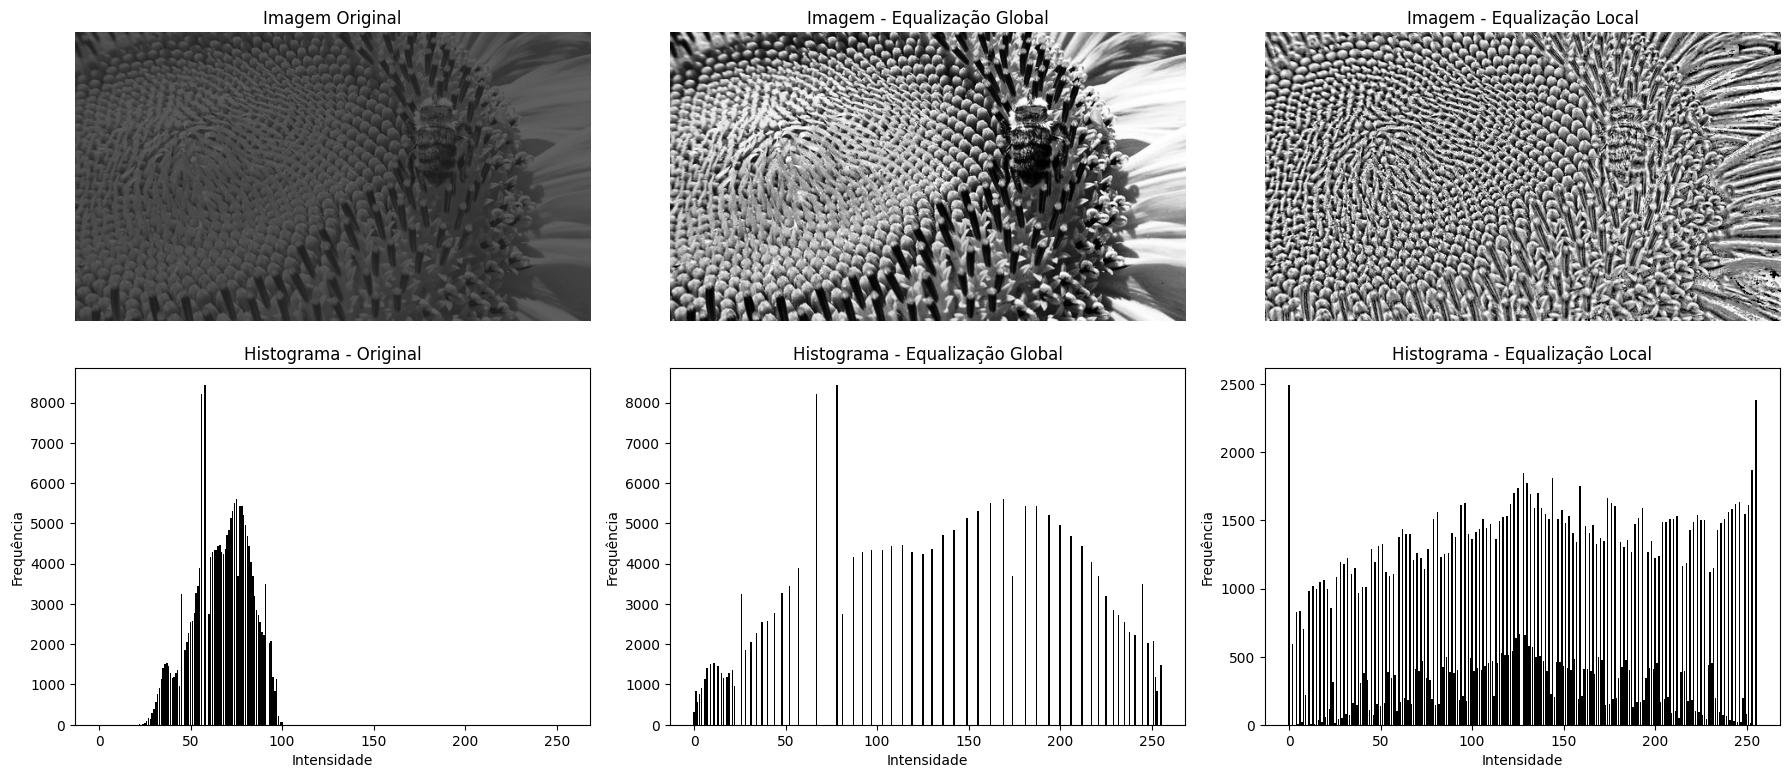

In [ ]:
#Teste com a primeira imagem
img = cv2.imread("flower_bee.png")
img_cinza = convert_tons_cinza(img)
histograma = calcula_histograma(img_cinza)
equaliza_global = equalizacao_global(img_cinza)
histograma_equalizada = calcula_histograma(equaliza_global)
img_local_eq = equalizacao_local(img_cinza, (11,11))
histograma_equalizada2 = calcula_histograma(img_local_eq)
intensidades = list(range(256))
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

axs[0, 0].imshow(img, cmap ='gray')
axs[0, 0].set_title("Imagem Original")
axs[0, 0].axis('off')
axs[0, 1].imshow(equaliza_global, cmap ='gray')
axs[0, 1].set_title("Imagem - Equalização Global")
axs[0, 1].axis('off')
axs[0, 2].imshow(img_local_eq, cmap ='gray')
axs[0, 2].set_title("Imagem - Equalização Local")
axs[0, 2].axis('off')

axs[1, 0].bar(intensidades, histograma, color='black')
axs[1, 0].set_title("Histograma - Original")
axs[1, 0].set_xlabel("Intensidade")
axs[1, 0].set_ylabel("Frequência")

axs[1, 1].bar(intensidades, histograma_equalizada, color='black')
axs[1, 1].set_title("Histograma - Equalização Global")
axs[1, 1].set_xlabel("Intensidade")
axs[1, 1].set_ylabel("Frequência")

axs[1, 2].bar(intensidades, histograma_equalizada2, color='black')
axs[1, 2].set_title("Histograma - Equalização Local")
axs[1, 2].set_xlabel("Intensidade")
axs[1, 2].set_ylabel("Frequência")
plt.tight_layout()
plt.show()


Temos que a imagem original consiste em uma foto em tons de cinza com baixa luminosidade e com pouca variedade de tons. Ao aplicar a equalização utilizando o histograma global, houve um aumento no que condiz aos contrastes presentes na imagem, tornando bem mais nítida a flor e a abelha presentes na foto. Quanto ao histograma obtido, temos que, quando comparado ao histograma original, a distribuição foi espalhada ao longo do espectro de cinza, exibindo uma distribuição mais ampla e com picos irregulares.

Quando submetida à equalização local, foram realçados ainda mais os detalhes em regiões menores, tornando ainda mais claros os tubulares da flor. Em contrapartida, houve também um realce nos ruídos e bordas, o que deixa a imagem com uma aparência mais artificial. Nota-se também que a abelha se mesclou aos demais detalhes presentes.

O histograma obtido é mais uniforme quando comparado aos demais, indicando que as intensidades presentes na imagem foram distribuídas de maneira mais equilibrada.


In [ ]:
#calculando os valores de media e da variancia para a imagens trabalhadas
media_original = np.mean(img_cinza)
var_original = np.var(img_cinza)
media_global = np.mean(equaliza_global)
var_global = np.var(equaliza_global)

print(f"Média da imagem original: {media_original:.3f}")
print(f"Variância da imagem original: {var_original:.3f}")
print(f"Média da imagem equalizada global: {media_global:.3f}")
print(f"Variância da imagem equalizada global: {var_global:.3f}")
print(f"Média da imagem equalizada local: {np.mean(img_local_eq):.3f}")
print(f"Variância da imagem equalizada local: {np.var(img_local_eq):.3f}")

Média da imagem original: 108.994
Variância da imagem original: 130.882
Média da imagem equalizada global: 132.477
Variância da imagem equalizada global: 5256.559
Média da imagem equalizada local: 150.720
Variância da imagem equalizada local: 5363.669


O resultados demonstram que a imagem original possui uma média baixa e um variância pequena, o que é esperado visto que é uma imagem escura e com poucas variações de tons como mostrado no histograma original, após o processo de equalização global temos eu houve um aumento significativo na média e na variância obtidos justamente pelo processo redistribuição dos pixels por toda a faixa dos tons de cinza [0,255]. Por fim, temos que o resultado obtido para a equalização local segue a mesma tendência de crescimento visto no processo global, onde a média é ligeiramente maior e  a variânica menor quando comparada a equalização global ressaltando o fato de preservar mais os detalhes finos e locais presentes na imagem, o que reduz a diferença entre os extremos na variância.

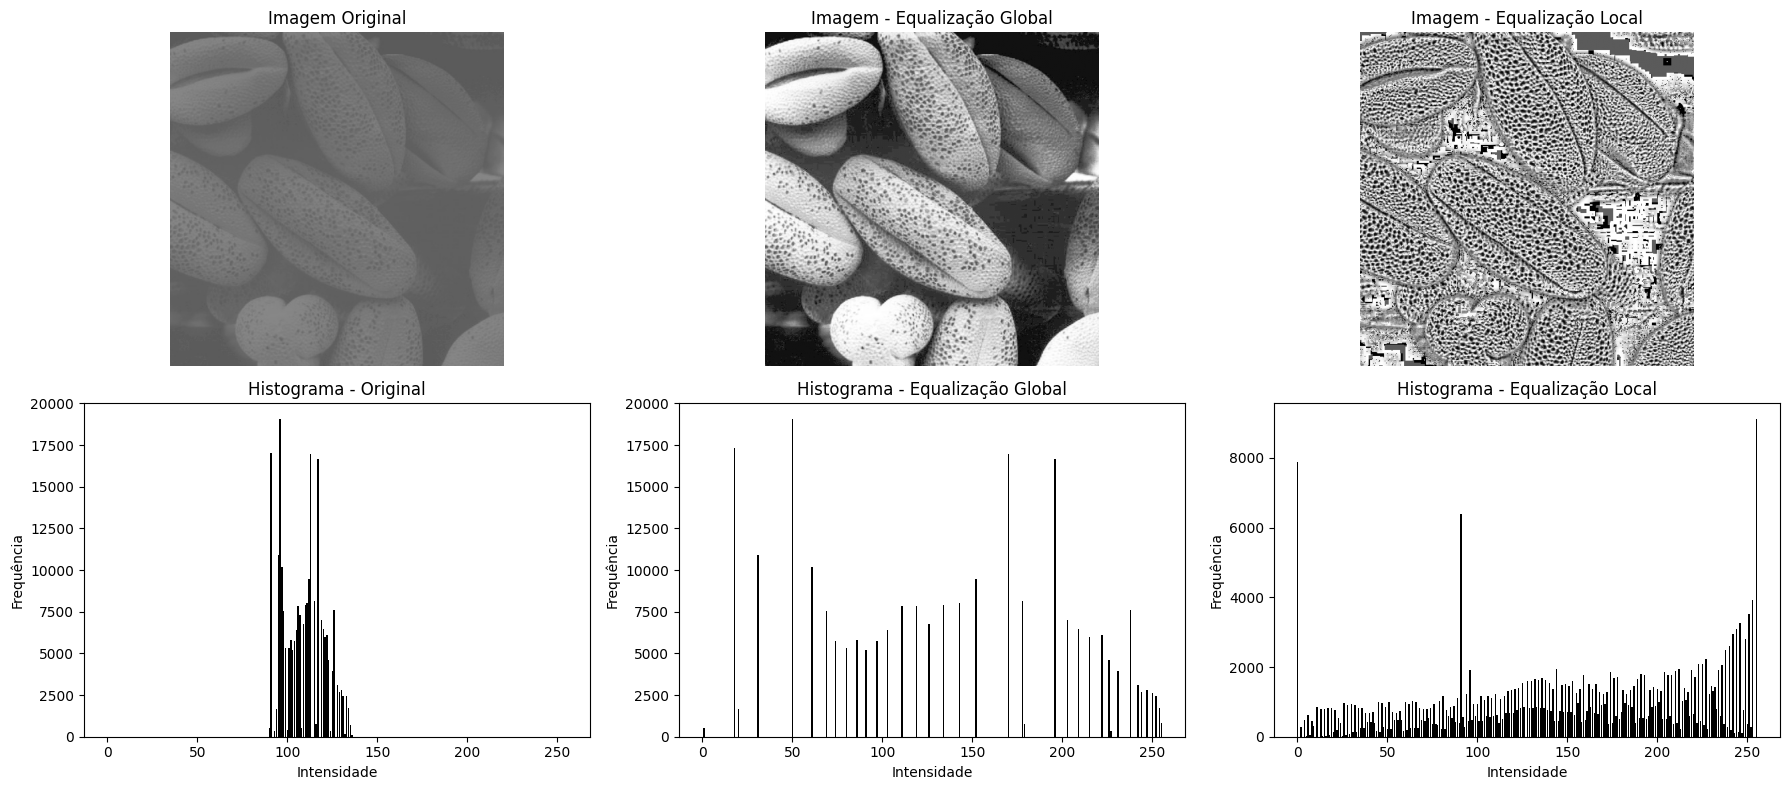

In [ ]:
#teste com a segunda imagem
img = cv2.imread("Fig3.15(a).jpg")
img_cinza = convert_tons_cinza(img)
histograma = calcula_histograma(img_cinza)
equaliza_global = equalizacao_global(img_cinza)
histograma_equalizada = calcula_histograma(equaliza_global)
img_local_eq = equalizacao_local(img_cinza, (11,11))
histograma_equalizada2 = calcula_histograma(img_local_eq)
intensidades = list(range(256))
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

axs[0, 0].imshow(img,cmap ='gray')
axs[0, 0].set_title("Imagem Original")
axs[0, 0].axis('off')
axs[0, 1].imshow(equaliza_global,cmap ='gray')
axs[0, 1].set_title("Imagem - Equalização Global")
axs[0, 1].axis('off')
axs[0, 2].imshow(img_local_eq, cmap ='gray')
axs[0, 2].set_title("Imagem - Equalização Local")
axs[0, 2].axis('off')

axs[1, 0].bar(intensidades, histograma, color='black')
axs[1, 0].set_title("Histograma - Original")
axs[1, 0].set_xlabel("Intensidade")
axs[1, 0].set_ylabel("Frequência")

axs[1, 1].bar(intensidades, histograma_equalizada, color='black')
axs[1, 1].set_title("Histograma - Equalização Global")
axs[1, 1].set_xlabel("Intensidade")
axs[1, 1].set_ylabel("Frequência")

axs[1, 2].bar(intensidades, histograma_equalizada2, color='black')
axs[1, 2].set_title("Histograma - Equalização Local")
axs[1, 2].set_xlabel("Intensidade")
axs[1, 2].set_ylabel("Frequência")
plt.tight_layout()
plt.show()

Como pode ser observado a imagem original também se trata de uma imagem em tons de cinza em um tom desbotado onde estão fotogrados amostras de polén obtidas de uma flor, ao ser submetida a equalização global o resultado é uma imagem que teve seus contornos e brilho realçados, entregando uma melhor separação entre os tons claros e escuros. Quando submetida ao processo de equalização global a imagem teve seu contraste ainda mais elevado, ocasionando o surgimento de ruídos e distorções. Quanto aos histogramas temos que na imagem original o mesmo fica restrito ao inteveralo de 100 a 130 o que ocasiona a qualidade opaca da foto, ao ser submetida equalização global houve a redistribuição dos níveis de cinza, mas de uma maneira muito irregular e para o processo de equalização local obteve-se um histograma  com uma faixa de cinza bem mais bem distribuída em relação aos resultados anteriores, mas com o surgimento de ruídos de borda na imagem.

In [ ]:
print(f"Média da imagem original: {media_original:.3f}")
print(f"Variância da imagem original: {var_original:.3f}")
print(f"Média da imagem equalizada global: {media_global:.3f}")
print(f"Variância da imagem equalizada global: {var_global:.3f}")
print(f"Média da imagem equalizada local: {np.mean(img_local_eq):.3f}")
print(f"Variância da imagem equalizada local: {np.var(img_local_eq):.3f}")

Média da imagem original: 108.994
Variância da imagem original: 130.882
Média da imagem equalizada global: 132.477
Variância da imagem equalizada global: 5256.559
Média da imagem equalizada local: 150.720
Variância da imagem equalizada local: 5363.669


A imagem original tinha uma variância baixa de somente 130.88  justificado pelo histograma concentrado em uma faixa relativamente estreita, além de uma média de 108.99. Ao ser submetida a equalização global a redistribuição do valores dos pixels nos tons de cinza fez com que a variância sofresse um grande aumento, sendo justificado pela melhora no contraste, já  na equalização local  temos foi obtida uma média superior aos casos anteriores, além de uma variância  também superior, mas visualmente apresentou um realce excessivo das bordas e dos ruídos presentes na imagem.
Analisando os resultados obtidos para as duas imagens temos que o processo de equalização global se mostrou eficaz no que conidz a melhorar a  qualidade da  imagem, enquanto para o processo de equalização  local apesar de ter se obtido uma melhora no constrate da imagem para ambos os casos pode ser visulizar o aparecimento de ruídos, o que deixa evidente a necessidade de se tomar cuidado com os paramêtros utilizados no processo como o tamanho da janela.

2) Reproduce Example 3.12 of the textbook (3rd edition).

O exemplo reproduzido do livro consiste em um procedimento para realizar o realce local de contraste utilizando estatísticas de histograma. Para se obter um resultado semelhante ao apresentado nao exemplo, foi desenvolvido um algoritmo que segue a descrição da resolução fornecida no texto.

A função implementada recebe como entrada a imagem a ser processada, e internamente cria uma nova imagem inicialmente vazia, onde serão inseridos os pixels realçados (ou mantidos, quando não houver realce).

O processo de decisão para substituir um pixel da imagem original por um pixel realçado utiliza o método da janela deslizante, que percorre a imagem extraindo pequenas subáreas. Para cada subjanela, identifica-se o pixel central, que será analisado quanto aos critérios de realce.

Esse pixel é realçado se duas condições forem atendidas:

  1. A média local da janela $(m_L)$ é menor que $m_L ≤ K_0 ⋅ m_g$​, indicando uma região escura;
  
  2. O desvio padrão local (σ_L) está dentro do intervalo $K_1⋅σ_G ≤ σ_L≤ K_2⋅σ_G ⋅K_1​⋅σ_G​≤σL​≤K_2​⋅σ_G$​ ,onde $σ_G$ é o desvio padrão global sugerindo presença de textura.

Quando essas condições são satisfeitas, o valor do pixel central é multiplicado pelo fator de realce EE, aumentando sua intensidade. Caso contrário, o pixel é mantido inalterado.

/tmp/ipython-input-7-3828172075.py:12: RuntimeWarning: overflow encountered in scalar add
  mg = mg + img[i, j]
/tmp/ipython-input-7-3828172075.py:40: RuntimeWarning: overflow encountered in scalar add
  md_local = md_local + img_analisada[i, j]


(np.float64(-0.5), np.float64(251.5), np.float64(297.5), np.float64(-0.5))

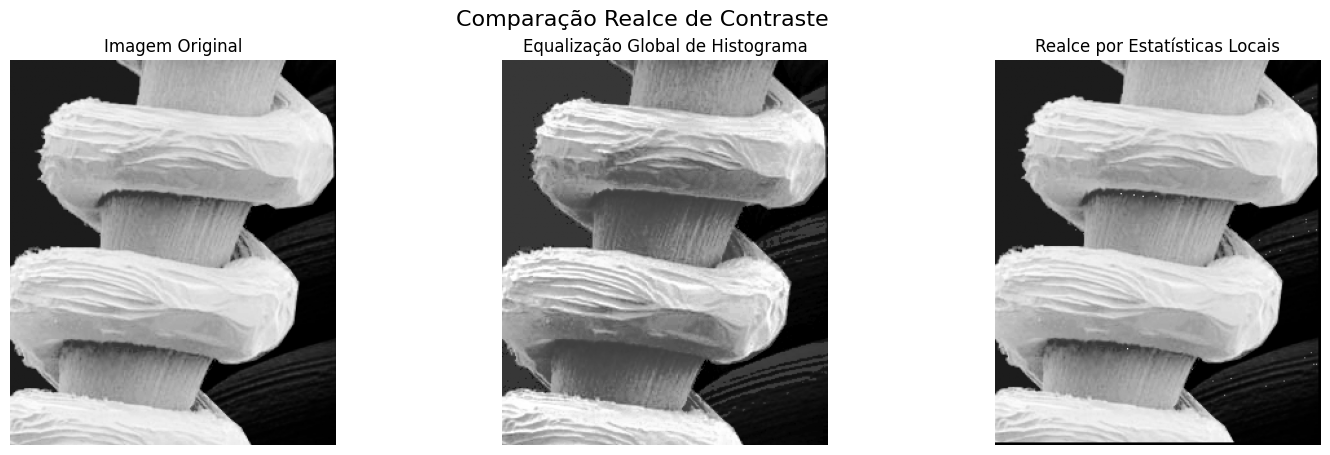

In [ ]:
def aplica_realce_global(img, E, K, janela):
    altura, largura = img.shape
    # calculando os parâmetros da janela:
    offset = janela // 2
    # Criando uma imagem vazia para o processo de realce:
    img_realcada = np.zeros((altura, largura), dtype=img.dtype)

    # Obtendo a média global dos pixels:
    mg = 0
    for i in range(altura):
        for j in range(largura):
            mg = mg + img[i, j]
    mg = mg / (altura * largura)

    # Obtendo o desvio padrão global da imagem:
    dvg = 0
    aux = 0
    for i in range(altura):
        for j in range(largura):
            aux = (img[i, j] - mg) ** 2
            dvg = dvg + aux
    dvg = dvg / (altura * largura)

    # desvio padrão global:
    dpg = np.sqrt(dvg)

    # Processo de analise dos pixels da imagem utilizando
    # os valores globais encontrados:
    for x in range(0, altura - janela + 1):
        for y in range(0, largura - janela + 1):
            img_analisada = img[x:x+janela, y:y+janela]
            pixel_central = img_analisada[janela//2, janela//2]
            md_local = 0
            dv_local = 0
            dp_local = 0

            # percorrendo todos os pixels da imagem analisada pela janela:
            for i in range(img_analisada.shape[0]):
                for j in range(img_analisada.shape[1]):
                    md_local = md_local + img_analisada[i, j]

            # Obtendo a media local a partir da imagem analisada pela janela:
            md_local = md_local / (img_analisada.shape[0] * img_analisada.shape[1])
            aux = 0

            # calculando o desvio padrão local:
            for i in range(img_analisada.shape[0]):
                for j in range(img_analisada.shape[1]):
                    aux = (img_analisada[i, j] - md_local) ** 2
                    dv_local = dv_local + aux
            dv_local = dv_local / (img_analisada.shape[0] * img_analisada.shape[1])

            # Calculando o desvio local padrão:
            dp_local = np.sqrt(dv_local)

            # Processo de decisão se a area é escura para aplicacao do realce:
            if md_local <= K[0] * mg:
                if K[1] * dpg <= dp_local <= K[2] * dpg:
                    img_realcada[x, y] = E * pixel_central
                else:
                    img_realcada[x, y] = pixel_central
            else:
                img_realcada[x, y] = pixel_central

    return img_realcada

#Carregando a imagem utilizada:
img_2_2 = cv2.imread ('Fig3.24.jpg', cv2.IMREAD_GRAYSCALE)
E = 4
K = [0.4,0.02,0.4]
janela = 3
img_realcada = aplica_realce_global(img_2_2, E, K, janela)
#Para obter a segunda imagem irei utilizar a implementação do histograma global da questão 1
img_2_2_HG = equalizacao_global(img_2_2)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparação Realce de Contraste', fontsize=16)
axs[0].imshow(img_2_2, cmap='gray')
axs[0].set_title('Imagem Original')
axs[0].axis('off')
axs[1].imshow(img_2_2_HG, cmap='gray')
axs[1].set_title('Equalização Global de Histograma')
axs[1].axis('off')
axs[2].imshow(img_realcada, cmap='gray')
axs[2].set_title('Realce por Estatísticas Locais')
axs[2].axis('off')




Como pode ser observado a imagem original possuía um constrate reduzido,com baixa visibililidade de detalhes, ao se utilizar o metódo da equalização global do histograma temos é feita uma redistribuição dos níveis de cinza da imagem a partir da aplicação do histograma, como resultado temos que o espiral presente no fio tem contornos mais destacados, o fundo escuro presente na imagem também foi destacado.

Por fim, o metódo utilizando realce por estatistícas locais se mostrou eficaz no procedimento de realce visto que usa os critérios para definir se um pixel deve ou não ser realçado, logo se destacou as partes que estavam mal iluminadas, sem comprometer os detalhes presentes já visíveis, se mostrando como um metódo eficaz  para preservar estrutura e sumprimir o ruído a partir da operação somente em pontos onde o realce é realmente necessário.

3) Make a routine that implements an NxN (N must be an odd number) spatial
convolution mask. You must discuss possible solutions for padding the borders and
implement one of them. Evaluate the implemented routine on the lena.tif image, for
the following cases: a) Low-Pass Filter, b) Laplacian filter (adding the original
image to the result), c) Sobel filter (pass the two masks and return the image of the
gradient magnitude). Show the obtained images and analyze them.

Para se realizar a questão 3, inicialmente foi feita a implementação das funções necessárias para o processo da aplicação dos filtros. A base para o uso dos filtros é o uso da convolução. Nessa resolução, foi produzida uma função de convolução a ser usada pelos três filtros testados, feita de forma manual. Neste caso, para cada pixel presente na imagem, temos que é calculada a soma ponderada dos vizinhos do pixel analisado, de acordo com a máscara implementada. Para um funcionamento correto do método, é necessária a inserção de padding na imagem. Nesse caso, o processo escolhido para inserção de padding foi a replicação das bordas, onde os valores dos pixels presentes na imagem são utilizados no processo de preenchimento. Isso garante que a convolução realmente seja feita em toda a imagem, inclusive nos pixels presentes nas bordas.

In [ ]:
def insert_padding(img, mask):
    #Extração dos valores da dimensão da imagem e a dimensão da máscara utilizada.
    img_alt, img_larg= img.shape
    alt_mask, larg_mask = mask.shape
    #Calculo da dimensão dos paddings utilizados
    pad_alt = alt_mask // 2
    pad_larg = larg_mask // 2
    #Calculo das dimensões da nova imagem considerando o complemento dos pixels considerando o padding:
    new_alt = img_alt + 2 * pad_alt
    new_larg = img_larg + 2 * pad_larg
    #Inicilizando uma nova imagem vazia utilizada para receber a nova imagem com o padding inserido:
    img_aux = np.zeros ((new_alt, new_larg))
    #Criando a imagem com padding:
    #Como a imagem já se encontra em tons de cinza a conta considera somente a existencia de um canal.
    img_aux = np.zeros((new_alt, new_larg), dtype=img.dtype)

    #INsere o padding a partir da replicação das bordas da imagens :
    #Copia a imagem original para o centro:
    img_aux[pad_alt:pad_alt + img_alt, pad_larg:pad_larg + img_larg] = img
    #copia as bordas da imagem :
    img_aux[0:pad_alt, pad_larg:pad_larg + img_larg] = img[0, :]
    img_aux[new_alt - pad_alt:, pad_larg:pad_larg + img_larg] = img[-1, :]
    img_aux[:, 0:pad_larg] = img_aux[:, pad_larg:pad_larg + 1]
    img_aux[:, new_larg - pad_larg:] = img_aux[:, new_larg - pad_larg - 1:new_larg - pad_larg]

    return img_aux

def convulational_mask (img, mask):
    #criando a mascara de convolucao utilizada:
    mask = np.array(mask)
    img_alt, img_larg= img.shape
    img_padding = insert_padding(img, mask)
    img_result = np.zeros((img_alt, img_larg), dtype=float)
    #Obtendo os limites do processo de convolução:
    alt_mask, larg_mask = mask.shape
    a = alt_mask // 2
    b = larg_mask // 2


    # Processo de convolução na imagem:
    for x in range (img_alt):
        for y in range (img_larg):
            result_aux = 0
            for s in range (-a , a+1):
                for t in range (-b, b+1):
                    result_aux += mask[s+a, t+b] * img_padding[a+s+x, b+t+y]

            img_result [x,y] =result_aux

    return img_result

#Criando o filtros testados:
low_pass = (1/9) * np.ones((3,3))
laplacian = [[-1, -1, -1],[-1,  8, -1],[-1, -1, -1]]
sobel_x = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
sobel_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]


#Carreagando a imagem utilizada:
img_lena = cv2.imread ('lena.tif', cv2.IMREAD_GRAYSCALE)

#Aplicando o filtro passa_baixa:
img_low_pass = convulational_mask(img_lena, low_pass)

#Aplicando o filtro laplaciano e somando a imagem original:
img_laplacian = convulational_mask (img_lena, laplacian)
img_laplacian_final = 255 * (img_laplacian- np.min(img_laplacian)) / (np.max(img_laplacian) - np.min(img_laplacian))

#Obtendo a magnitude a partir da aplicação do filtro sobel:
img_sobel_x = convulational_mask (img_lena, sobel_x)
img_sobel_y = convulational_mask (img_lena, sobel_y)
img_sobel_magnitude = np.sqrt(img_sobel_x**2 + img_sobel_y**2)



Para implementar o filtro low pass foi utilizado o kernel:
$$
G_{Low Pass} = (1/9) * \begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}
$$




(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

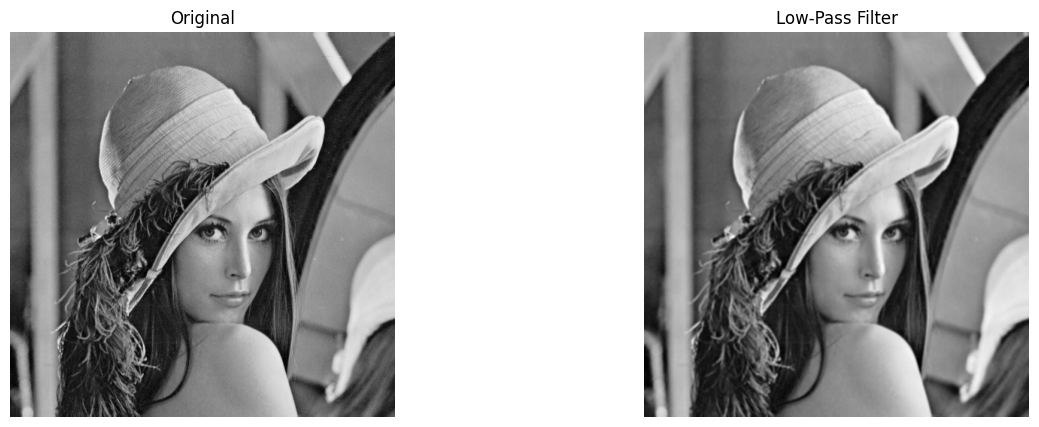

In [ ]:
#Exibindos os resultados obtidos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img_lena, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_low_pass, cmap='gray')
axs[1].set_title('Low-Pass Filter')
axs[1].axis('off')

Como pode ser notado, o filtro passa-baixa aplicado suaviza a imagem, fazendo uma redução dos ruídos e detalhes mais finos presentes na foto.

Para implementar o filtro laplaciano foi utilizado o kernel:
$$
G_{laplaciano} = \begin{pmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}
$$

Após o processo de passagem pelo filtro também foi feita a adição da imagem filtrada a imagem original.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

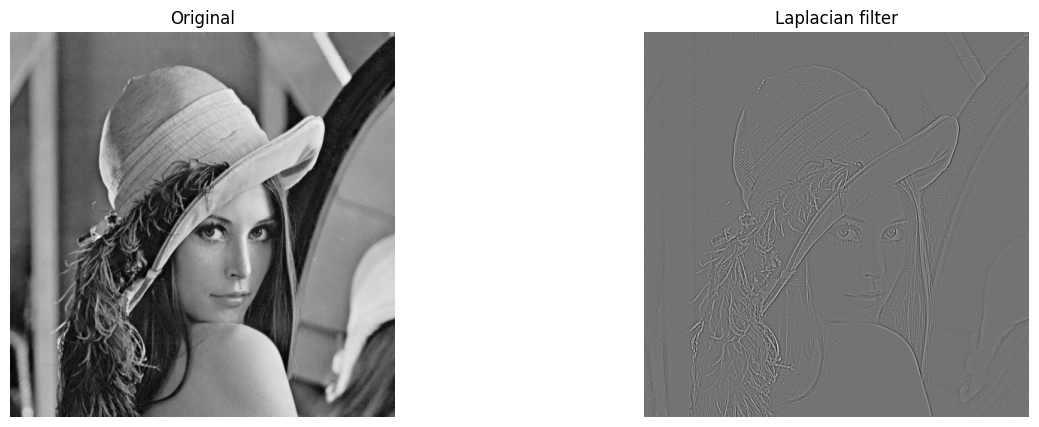

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img_lena, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_laplacian_final, cmap='gray')
axs[1].set_title('Laplacian filter')
axs[1].axis('off')

O filtro laplaciano aplicado fez um realce nas bordas da imagem, deixando destacados os contornos do rosto e detalhes como o adereço no chapéu e a moldura do espelho ao fundo.

Para implementar o filtro de sobel foi considerado que os kernels para o sobel x e sobel y utilizados foram:
$$
G_x = \begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{pmatrix}
\quad
G_y = \begin{pmatrix}
-1 & -2 & -1 \\
0 & 0 & 0\\
1 & 2 & 1
\end{pmatrix}
$$

Para se obter o resultado final o resultado obtido pela aplicação da imagem ao sobel_x e sobel_y ambos os resultados foram utilizados para o calculo da magnitude:
$$
img_{magnitude} = \sqrt{img_{sobel\_x}^{2} + img_{sobel\_y}^{2}}
$$

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

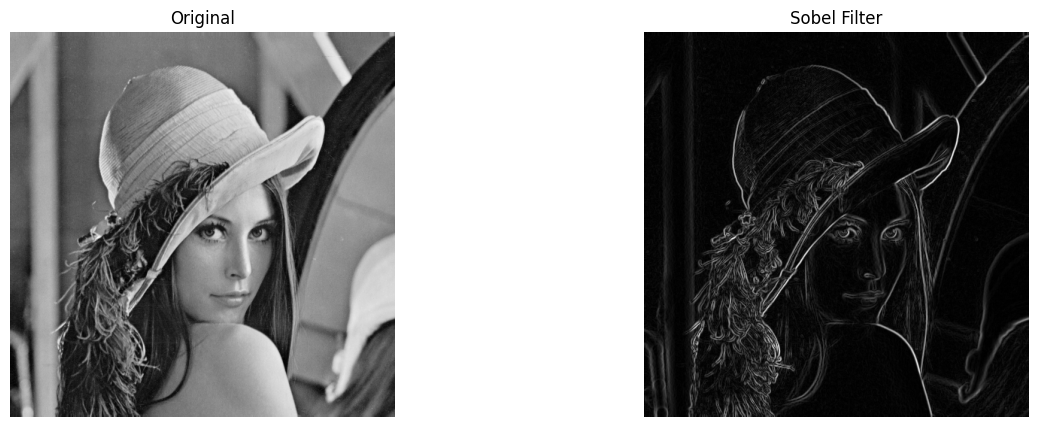

In [ ]:
#Exibindos os resultados obtidos:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img_lena, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_sobel_magnitude, cmap='gray')
axs[1].set_title('Sobel Filter')
axs[1].axis('off')

Como resposta obtida, temos o destaque somente das bordas presentes na imagem, obtido principalmente pelo cálculo do gradiente de magnitude.

Para efeito comparativo na imagem a seguir são exibidos os resultados obtidos para todos os procedimentos de filtragem testados.

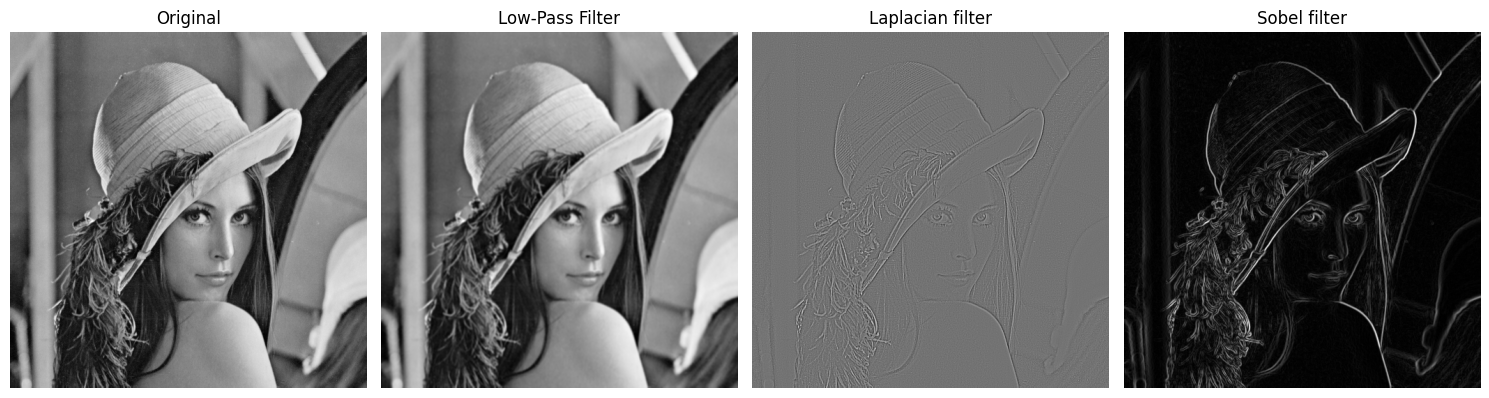

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(img_lena, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_low_pass, cmap='gray')
axs[1].set_title('Low-Pass Filter')
axs[1].axis('off')
axs[2].imshow(img_laplacian_final, cmap='gray')
axs[2].set_title('Laplacian filter')
axs[2].axis('off')
axs[3].imshow(img_sobel_magnitude, cmap='gray')
axs[3].set_title('Sobel filter')
axs[3].axis('off')
plt.tight_layout()
plt.show()

Analisando as imagens obtidas, os procedimentos de filtragem reproduzidos se mostraram eficazes, obtendo-se resultados dentro do esperado. Para a aplicação do filtro passa-baixa, o resultado encontrado foi uma imagem com uma suavização muito leve. A aplicação do laplaciano com adição do resultado original resultou em uma imagem em tom de cinza, onde ficam mais claros os contornos. E, por fim, para a magnitude utilizando Sobel, a imagem obtida é totalmente negra, apresentando somente as bordas e detalhes mais relevantes do original, mas com detalhes bem mais evidentes do que os visualizados na aplicação do filtro laplaciano.

4) Write a routine that implements in the frequency domain: a) a Butterworth low-pass filter of order n=1 and apply this filter on the image Fig3.35(a).jpg for twovalues of cutoff frequency (D0); b) a Butterworth low-pass filter of order n=8 on the same image and same cutoff frequencies; c) an ideal filter on the same image and same cutoff frequencies. Compare and comment on the results.

O exercício proposto tem por objetivo testar a aplicação de filtro no domínio em frequência, por meio do uso da transformada de Fourier. Para executar esse procedimento, foram implementadas três funções. Partindo do princípio de funcionamento do uso de filtros no domínio da frequência, primeiramente foi produzida a função insere_padding_freqDomain() que, basicamente, tem por objetivo dobrar o tamanho da imagem original por meio da inserção de pixels com valor zero em suas bordas. Isso tem por objetivo reduzir o surgimento de aliasing e sobreposição circular durante a transformada de Fourier. Essa imagem com padding é passada para a função centraliz_transf(), que executa a multiplicação dos pixels da imagem por $(-1)^{x+y}$. Esse processo centraliza o espectro de frequência no centro da imagem (origem). A resolução proposta utiliza dois tipos de filtro. Em ideal_filter() é produzido um filtro que corta, sem exceções, todas as frequências superiores a $D_0$, seguindo a lógica:
$$
H(u,v) =
\begin{cases}
  1, & \text{se } D(u,v) \leq D_0 \\
  0, & \text{se } D(u,v) > D_0
\end{cases}
$$

A função butterworth_low_pass() faz a atenuação das frequências acima de $D_0$ de maneira suave. A ordem do filtro $n$ controla a suavidade do corte:

$$
H(u,v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}
$$

Para simplificar o processo de produção da resolução, foram utilizadas as funções prontas para cálculo da transformada np.fft.fft2() e da transformada inversa np.fft.ifft2(), para obtenção da imagem filtrada.

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

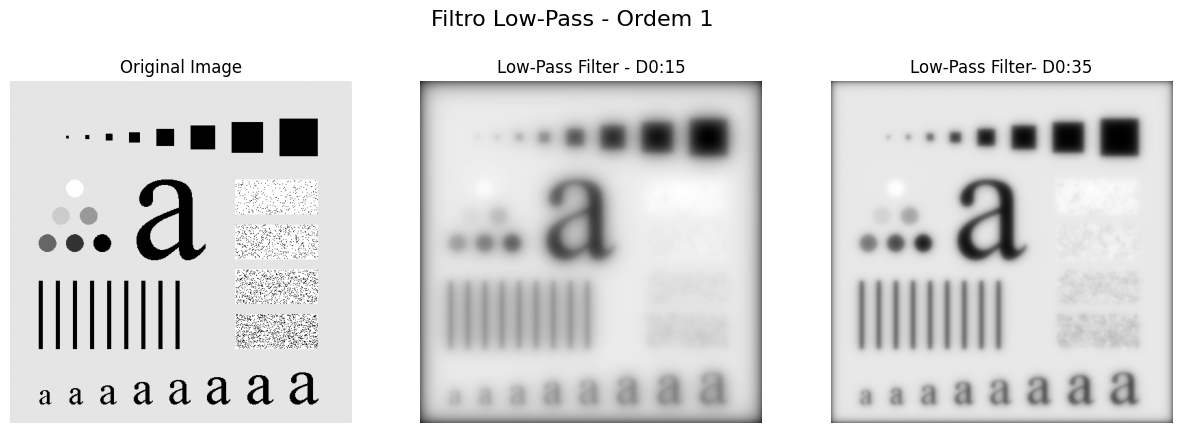

In [ ]:
def insere_padding_freqDomani (img, altura,largura):
  # Define as novas dimensões da imagem, que serão o dobro das originais.
    P = 2*altura
    Q = 2*largura
    # Cria uma nova imagem preenchida com zeros (preta) com as novas dimensões.
    img_Z_pad = np.zeros((P, Q), dtype=img.dtype)
    # Copia os pixels da imagem original para o canto superior esquerdo da nova imagem maior.
    for i in range(altura):
        for j in range(largura):
            img_Z_pad[i, j] = img[i, j]
    return(img_Z_pad)

def centraliz_transf(img):
  # Obtém a altura e a largura da imagem de entrada.
    altura, largura = img.shape
    x = np.arange(altura).reshape(-1, 1)
    y = np.arange(largura).reshape(1, -1)
    # Calcula o fator de centralização (-1)^(x+y).
    fator = (-1) ** (x + y)

    # Multiplica a imagem original pelo fator. Esta operação irá efetivamente
    # centralizar o espectro quando a Transformada de Fourier for aplicada.
    img_centrada = img * fator
    return img_centrada

def ideal_filter (P, Q, D0):
    #Calculo do centro e criacao da matriz para receber o filtro
    H = np.zeros((P, Q), dtype=np.float64)
    centro_p = P//2
    centro_q = Q//2
    #preenchimento do filtro criado
    for i in range (P):
        for j in range (Q):
            element = np.sqrt((i - centro_p)**2 + (j - centro_q)**2)

            if element <= D0 :
                H [i,j] = 1.0
            else:
                H [i,j] = 0.0

    return H

def butterworth_low_pass (P, Q, D0, n=1 ):
    #Calculo do centro e criacao da matriz para receber o filtro
    H = np.zeros((P, Q), dtype=np.float64)
    centro_p = P//2
    centro_q = Q//2
    #preenchimento do filtro criado
    for i in range (P):
        for j in range (Q):
            element = np.sqrt((i - centro_p)**2 + (j - centro_q)**2)

            if element == 0 :
                H [i,j] = 1.0
            else:
                H [i,j] = 1.0 / (1.0 + (element/ D0)**(2*n))

    return H



def aplica_filtros (img, tipo_filtro, freq, n):
    altura, largura = img.shape
    img_padding = insere_padding_freqDomani(img, altura, largura)
    img_centralizada = centraliz_transf(img_padding)

    img_dft = np.fft.fft2(img_centralizada)

    P, Q = img_padding.shape

    if tipo_filtro == "butterworth_low_pass":
        H = butterworth_low_pass(P, Q, freq, n)
    elif tipo_filtro == "ideal_filter":
        H = ideal_filter(P, Q, freq)
    else:
        print("Tipo de filtro invalido..")
        return None

    img_filtr = H * img_dft

    #Revertendo a transformada:
    img_filtr_inv = np.fft.ifft2(img_filtr)
    #Revertendo a centralizacao da imagem filtrada:
    img_descentrada = np.zeros(img_filtr_inv.shape, dtype=np.complex128)
    for x in range(P):
        for y in range(Q):
            img_descentrada [x, y] = img_filtr_inv[x, y] * ((-1)**(x+y))

    img_filtr_final = np.real(img_descentrada)

    #processo de segmentacao para remocao dos paddings:
    img_final = img_filtr_final[0:altura, 0:largura]
    #normaliza a imagem final:
    img_final = np.clip(img_final, 0, 255).astype(np.uint8)

    return img_final


#Carregando a imagem utilizada temos:
img_exe_4 = cv2.imread("Fig3.35(a).jpg", cv2.IMREAD_GRAYSCALE)
freq = [15,35]
img_a_1  = aplica_filtros (img_exe_4,"butterworth_low_pass",freq[0],1)
img_a_2  = aplica_filtros (img_exe_4,"butterworth_low_pass",freq[1],1)
img_b_1  = aplica_filtros (img_exe_4,"butterworth_low_pass",freq[0],8)
img_b_2  = aplica_filtros (img_exe_4,"butterworth_low_pass",freq[1],8)
img_c_1  = aplica_filtros (img_exe_4,"ideal_filter",freq[0],None)
img_c_2  = aplica_filtros (img_exe_4,"ideal_filter",freq[1],None)
#Exibindos os resultados obtidos:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Filtro Low-Pass - Ordem 1', fontsize=16)
axs[0].imshow(img_exe_4, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img_a_1, cmap='gray')
axs[1].set_title(f'Low-Pass Filter - D0:{freq[0]}')
axs[1].axis('off')
axs[2].imshow(img_a_2, cmap='gray')
axs[2].set_title(f'Low-Pass Filter- D0:{freq[1]}')
axs[2].axis('off')



Como pode ser observado, para o teste utilizando o filtro passa-baixa de ordem 1, temos que, para a frequência de $d_0 = 15$, o resultado obtido foi uma suavização muito forte, com todos os detalhes finos apagados.
Para o filtro utilizando a frequência de corte de $d_0 = 35$, a suavização obtida é bem mais suave, e os detalhes são preservados, como contornos e as letras presentes. Não há presença de distorções graves na imagem, mas fica evidente que o resultado obtido com o aumento da frequência de corte é superior.

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

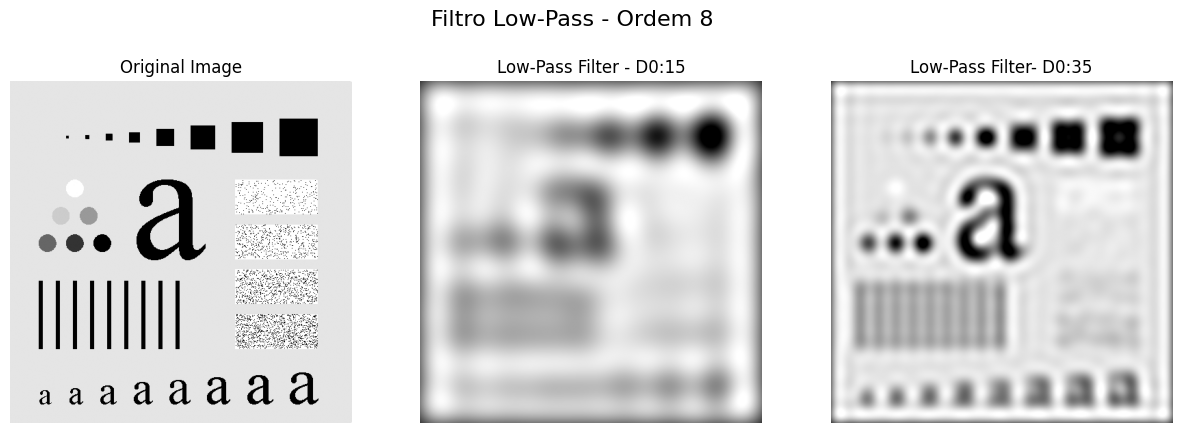

In [ ]:
#Exibindos os resultados obtidos letra b:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Filtro Low-Pass - Ordem 8', fontsize=16)
axs[0].imshow(img_exe_4, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img_b_1, cmap='gray')
axs[1].set_title(f'Low-Pass Filter - D0:{freq[0]}')
axs[1].axis('off')
axs[2].imshow(img_b_2, cmap='gray')
axs[2].set_title(f'Low-Pass Filter- D0:{freq[1]}')
axs[2].axis('off')




Ao aumentar a ordem do filtro para $n=8$, temos que ocorreu muita perda de informação da imagem original. Para a frequência $d_0 = 15$, a imagem obtida se encontra muito embaçada. Ao se aumentar a frequência de corte para $d_0 = 35$, a qualidade em relação à imagem original ainda é ruim, mas relativamente superior quando comparada à frequência anterior, com o aparecimento de ringing.

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

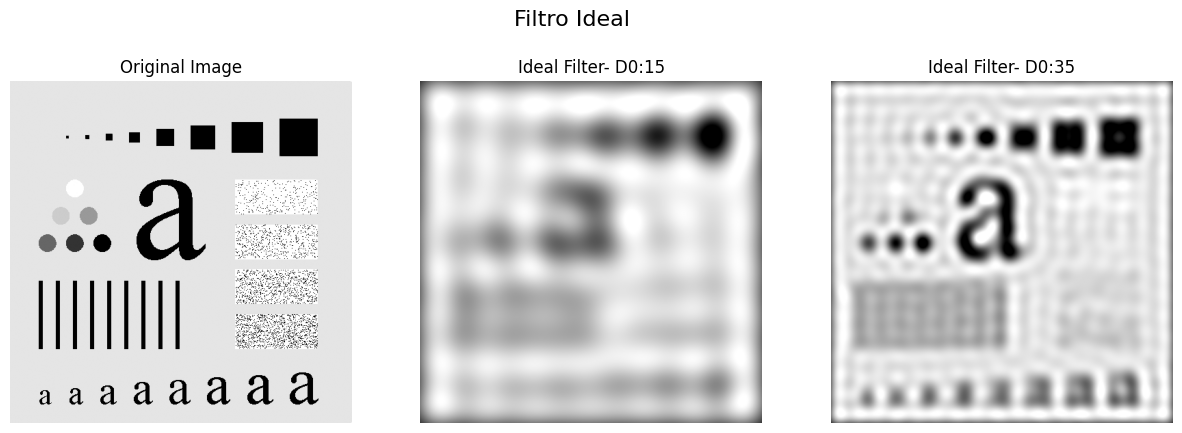

In [ ]:

#Exibindos os resultados obtidos letra c:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Filtro Ideal', fontsize=16)
axs[0].imshow(img_exe_4, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img_c_1, cmap='gray')
axs[1].set_title(f'Ideal Filter- D0:{freq[0]}')
axs[1].axis('off')
axs[2].imshow(img_c_2, cmap='gray')
axs[2].set_title(f'Ideal Filter- D0:{freq[1]}')
axs[2].axis('off')

A partir da aplicação de um filtro ideal, temos que, para a frequência de corte $d_0 = 15$, a suavização aplicada na imagem faz com que ocorra muita perda na qualidade da imagem, com o surgimento de ringing ao redor das bordas. Para uma frequência de corte $d_0 = 35$, ocorre uma melhora na imagem obtida, mas as linhas finas e detalhes menores somem completamente.

5) For the image mar-il.gif, correct the problem of poor illumination in 2 different ways (assume the multiplicative model between reflectance and illumination and discuss the solutions).

Para a resolução questão, foi desenvolvida a implementação de dois métodos para a correção da iluminação. Inicialmente, foi feita a produção de um algoritmo usando filtro homomórfico, que basicamente faz a correção no domínio da frequência, considerando que a imagem pode ser dividida em dois tipos de dados: iluminação e reflectância. Uma imagem resultante filtrada pode ser obtida ao se aplicar o log na transformada de Fourier da imagem e um filtro passa-alta mais suave; isso corrige a iluminação à medida que mantém os detalhes da imagem.
O segundo método implementado é a divisão espacial, que se baseia na estimativa da iluminação dividida para cada coluna presente na imagem e utiliza esse valor obtido para dividir os pixels presentes na imagem original, a fim de obter uma nova imagem com iluminação ajustada.

/tmp/ipython-input-16-628248059.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  img_final[i, j] = np.exp(img_filt_result[i, j] + 1)


(np.float64(-0.5), np.float64(226.5), np.float64(227.5), np.float64(-0.5))

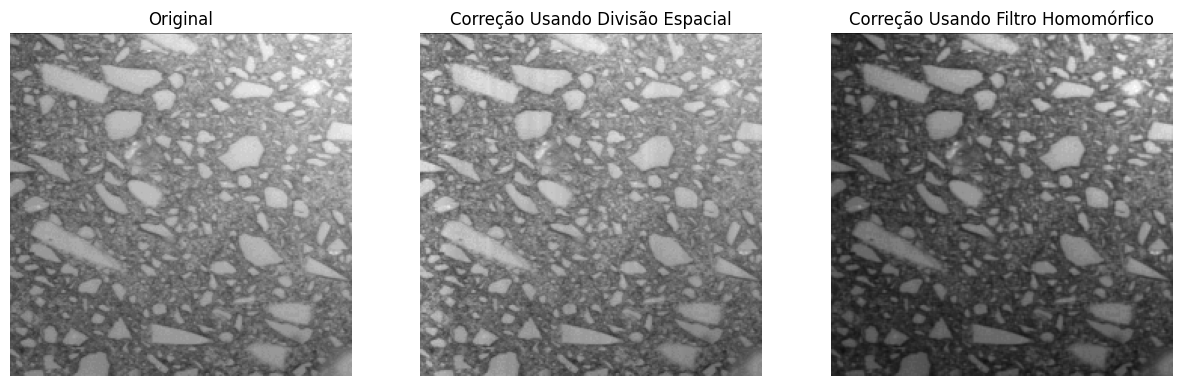

In [ ]:
def aplica_filtro_homorfico(img,g_H,g_L,D0 ,c):

    altura, largura = img.shape
    H = np.zeros((altura, largura), dtype=np.float64)
    img_log = np.zeros((altura, largura), dtype=np.float64)

    u_centro = largura //2
    v_centro = altura //2
    # Passa sobre cada pixel da matriz do filtro para calcular seu valor.
    for v in range(altura):
        for u in range(largura):
          # Calcula a distância euclidiana do ponto (u,v) até o centro.
            distancia = np.sqrt((u - u_centro)**2 + (v - v_centro)**2)
          # Calcula o termo Gaussiano da função de transferência do filtro.
            termo_exp = np.exp(-c * (distancia**2 / D0**2))
          # Aplica a fórmula do filtro homomórfico para o ponto (v,u).
            H[v, u] = (g_H - g_L) * (1 - termo_exp) + g_L

    #Transforma a imagem para o domínio do logaritmo.
    for i in range(altura):
        for j in range(largura):
            img_log[i, j] = np.log(img[i, j] + 1)

    #Transforma a imagem logarítmica para o domínio da frequência usando FFT.
    img_z = np.fft.fft2(img_log)
    #Aplica o filtro na imagem
    img_filtrada = img_z * H
    #Passa imagem novamente para o dominio espacial
    img_filt_result =np.fft.ifft2(img_filtrada)
    img_final = np.zeros((altura, largura), dtype=np.float64)
    #Aplica a exponencial para reverter a transformação logarítmica.
    for i in range(altura):
     for j in range(largura):
            img_final[i, j] = np.exp(img_filt_result[i, j] + 1)
    #Retorna a imagem filtrada
    return img_final

def aplica_div_espacial (img):
    altura, largura = img.shape
    #Obtendo a media da iluminacao para cada colunas
    ilumin_colunas = np.zeros(largura)
    reflect = np.zeros((altura, largura), dtype=np.float64)
    for i in range(altura):
     for j in range(largura):
         ilumin_colunas[j] = ilumin_colunas[j]+ img[i,j]
    #Obtem um vetor similar ao funcionamento da matriz de iluminacao , considerando a media de ilumincao por colunas.
    for i in range (len(ilumin_colunas)):
        ilumin_colunas[i] = ilumin_colunas[i] / altura

    #Obtendo a reflectancia:
    for i in range(altura):
     for j in range(largura):
         reflect[i,j] = img[i,j]/ ilumin_colunas[j]

    return reflect


img_5 = Image.open("mar-il.gif").convert("L")
img_np = np.array(img_5)
img_corrigida1 = aplica_filtro_homorfico(img_np,2,0.25,80,1)
img_corrigida2 = aplica_div_espacial(img_np)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_5, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_corrigida2, cmap='gray')
axs[1].set_title('Correção Usando Divisão Espacial')
axs[1].axis('off')
axs[2].imshow(img_corrigida1, cmap='gray')
axs[2].set_title('Correção Usando Filtro Homomórfico')
axs[2].axis('off')





Como pode ser visualizado na imagem original, temos que a iluminação não se encontra distribuída de maneira uniforme, apresentando regiões mais escuras e um local mais claro no canto superior da imagem. Ao submeter a mesma imagem ao método desenvolvido para a filtragem utilizando a correção por divisão espacial, temos que a imagem apresenta uma iluminação um pouco mais uniforme. Apesar disso, o método desenvolvido não foi capaz de melhorar completamente a imagem, apresentando uma iluminação inconsistente, principalmente no canto superior direito.

Quando submetida ao procedimento com o filtro homomórfico, temos que o resultado obtido é uma imagem com iluminação com tons mais equilibrados em toda a sua extensão, além de ter deixado a imagem com um contraste melhorado, tornando os detalhes da imagem mais nítidos. De uma maneira geral, ambos os métodos implementados foram capazes de melhorar a qualidade obtida para a iluminação, mas o resultado obtido com o uso do filtro homomórfico foi superior, ficando muito evidente a melhoria obtida.

6) Reduce the image frexp_1.png by alternately eliminating rows and columns.
Compare the original image with the reduced one. What happened to it? What
procedure could you apply to reduce this effect? Apply the solution devised to
avoid this effect in the reduced image. Compare the new image with the other two
and evaluate the result.

O procedimento utilizado para fazer a redução de imagem implementado consiste em remover as colunas e linhas de maneira alternada. Isso faz com que a imagem obtida tenha somente metade do tamanho da imagem original. De forma complementar ao processo de redução do tamanho da imagem, foram criadas mais duas funções que são utilizadas para corrigir os efeitos ocorridos na redução das imagens, que são centraliza_transformada() e reduz_imagem_passa_baixa().
A função centraliza_transformada() é a mesma utilizada em questões anteriores e basicamente serve para centralizar o espectro da transformada de Fourier. Já a função reduz_imagem_passa_baixa() é uma versão melhorada do processo de redução utilizando remoção de linhas e colunas, que aplica um filtro gaussiano passa-baixa para minimizar os defeitos provenientes do processo de redução da imagem.

In [ ]:
def reduz_imagem (img):
     #Extracao dos parametros da imagem original:
     altura, largura = img.shape
     nova_altura = altura // 2
     nova_largura = largura // 2
     img_reduzida = np.zeros((nova_altura, nova_largura), dtype=img.dtype)
     #Reduz a imagem guardando somente as colunas e linhas pares existentes.
     x = 0
     for i in range(altura):
        if i % 2 == 0:
            k = 0
            for j in range(largura):
                if j % 2 == 0:
                    img_reduzida[x, k] = img[i, j]
                    k += 1
            x += 1

     return img_reduzida


def centraliza_transformada(img):
    altura, largura = img.shape
    x = np.arange(altura).reshape(-1, 1)
    y = np.arange(largura).reshape(1, -1)
    fator = (-1) ** (x + y)
    img_centrada = img * fator
    return img_centrada

def reduz_imagem_passa_baixa (img,d0):
    #obtendo as cooordenadas de centro do filtro
    p, q = img.shape
    centro_p = p/2
    centro_q = q/2
    d_quad = np.zeros((p, q), dtype=np.float64)
    exp = np.zeros((p, q), dtype=np.float64)
    # construindo o filtro gaussiano passa-baixa:
    #calculo da distancia ao quadrado:
    for i in range(p):
     for j in range(q):
         d_quad [i, j] = (i - centro_p)**2 + (j - centro_q)**2
    #calculo dos expoentes:
    for i in range(p):
        for j in range(q):
            exp[i,j] = -1 * (d_quad[i,j]/ ((2*d0)**2))
    #criando o filtro gaussiano passa baixa
    H = np.exp(exp)

    #passar imagem para o dominio da frequencia
    img_fft = np.fft.fft2(centraliza_transformada(img))
    #aplica o filtro na imagem
    img_filtrada_f = img_fft * H
    img_filtrada = np.fft.ifft2(img_filtrada_f)
    #desfazendo o processo de centralizacao feita na passagem da imagem para o dominio da frequencia
    img_filtrada = np.real(img_filtrada)
    img_filtrada = centraliza_transformada(img_filtrada)
    img_filtrada = np.clip(img_filtrada, 0, 255)
    img_filtrada = img_filtrada.astype(np.uint8)

    nova_img_reduzida = reduz_imagem (img_filtrada)
    return nova_img_reduzida

img_6 = cv2.imread("frexp_1.png", cv2.IMREAD_GRAYSCALE)
img_reduzida = reduz_imagem(img_6)
img_reduzida_corrigida = reduz_imagem_passa_baixa (img_6,50)


O resultado obtido para a remoção simples de colunas e linhas de pixels presentes na imagem, sem nenhum tipo de pré-processamento, pode ser visualizado a seguir:

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

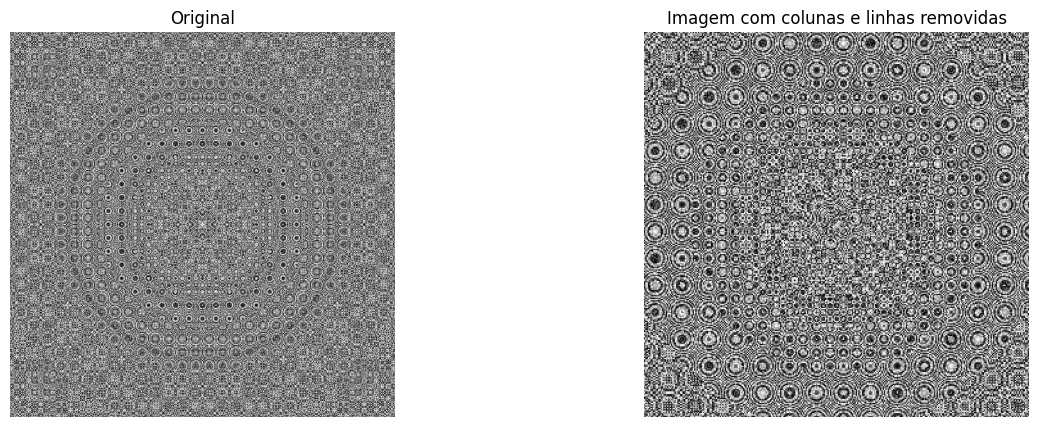

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img_6, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_reduzida, cmap='gray')
axs[1].set_title('Imagem com colunas e linhas removidas')
axs[1].axis('off')

Temos que a simples redução da quantidade de linhas e colunas de pixels presentes na imagem, de forma alternada, faz com que ocorra o surgimento de uma distorção quando comparada à imagem original. Por ser uma imagem com muitos detalhes, temos que esse procedimento simples faz com que ocorra aliasing, com a substituição dos detalhes da imagem por padrões diferentes dos originais. A solução proposta para minimizar o efeito basicamente consiste em filtrar a imagem utilizando um filtro passa-baixa, suavizando as bordas e texturas mais finas antes do processo de redução, permitindo a obtenção de uma imagem mais similar à original, como exibido no resultado a seguir.

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

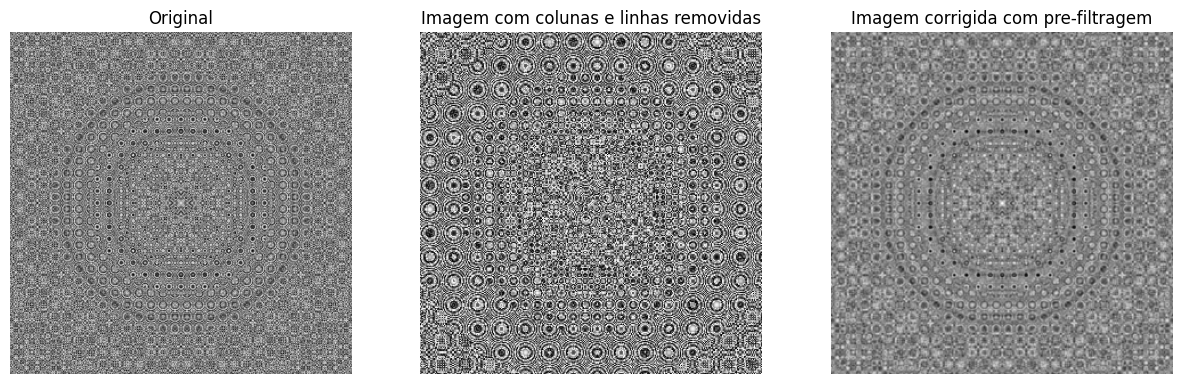

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_6, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(img_reduzida, cmap='gray')
axs[1].set_title('Imagem com colunas e linhas removidas')
axs[1].axis('off')
axs[2].imshow(img_reduzida_corrigida, cmap='gray')
axs[2].set_title('Imagem corrigida com pre-filtragem')
axs[2].axis('off')

Como pode ser observado, a imagem obtida com um processo de pré-filtragem apresenta um resultado mais suave, mantendo os detalhes mais próximos da imagem original, além de ter mantido a textura mais próxima da original da imagem. Enquanto o método mais simples, que consiste somente em remover linhas e colunas de pixels da imagem, se mostrou ineficaz, justificado pelo surgimento de distorções e perdas na qualidade.

7) Reproduce Example 4.24 of the textbook (3rd edition).

O filtro implementado para a eliminação do ruído na imagem dos anéis de Saturno é do tipo rejeita-notch vertical. Ele foi construído com duas faixas simétricas de rejeição, posicionadas precisamente sobre as frequências de ruído que foram identificadas no espectro de magnitude da imagem. Inspirado no exemplo de referência, uma abertura foi inserida na região central das linhas de filtragem, controlada por um parâmetro de raio. Este espaço central evita a filtragem dos componentes de baixa frequência, onde se concentra a maior parte da energia do espectro. Após sua criação, este filtro é multiplicado pelo espectro da imagem e o resultado é convertido de volta para o domínio espacial através da Transformada de Fourier Inversa. Por fim, um processo de normalização é aplicado para gerar a imagem final, livre do ruído presente na original.

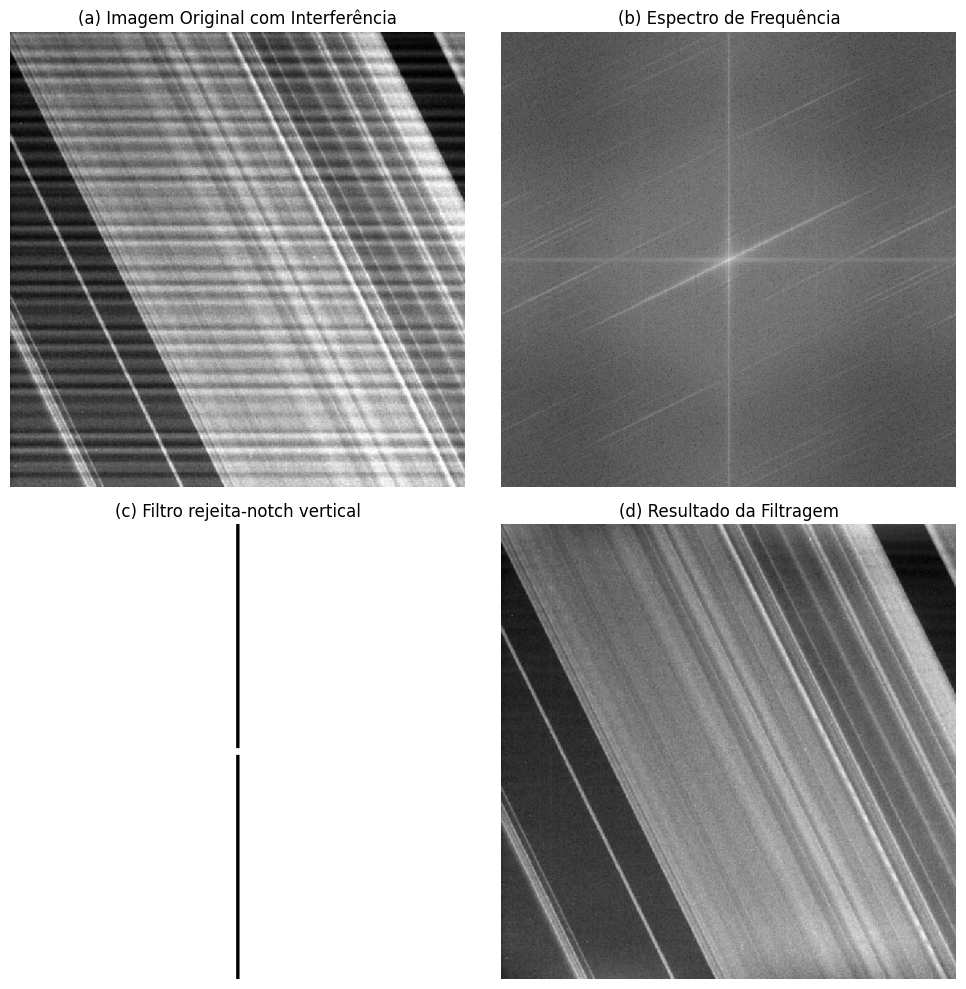

In [ ]:
def centraliza_transformada(img):
    #Executa o deslocamento da imagem para antes do calculo utilizando
    #Transformada discreta de Fourier
    altura, largura = img.shape
    x = np.arange(altura).reshape(-1, 1)
    y = np.arange(largura).reshape(1, -1)
    fator = (-1) ** (x + y)
    img_centrada = img * fator
    return img_centrada

def aplica_normalizacao (img):
     #Obtendo os extremos valores de pixel:
     min_value  = np.min (img)
     max_value = np.max (img)
     #Extraindo o tamanho da imagem:
     altura, largura =  img.shape
     img_normalizada = np.zeros((altura, largura), dtype=np.float64)

     if min_value == max_value:
        return np.zeros(img.shape, dtype=np.uint8)

     #fator de escala usando durante a normalizacao:
     escala = 255.0 / (max_value-min_value)
     #percorre a imagem fazendo a normalizacao
     for i in range(altura):
        for j in range(largura):
            pixel_antigo = img[i, j]
            pixel_novo = (pixel_antigo -  min_value) * escala
            img_normalizada[i, j] = pixel_novo

     return img_normalizada.astype(np.uint8)

def criar_filtro_rejeita_notch_vertical(img, largura_faixa, raio):
  #Extraindo os parametros da imagem a ser filtrada
  altura, largura = img.shape
  centro_u, centro_v = altura // 2, largura // 2
  #Cria o filtro notch utilizado
  filtro = np.ones((altura, largura), dtype=np.float32)

  #Desenha as faixas simétricas do filtro notch, como a ideia e uma reproducao
  #o codigo esta produzido de uma forma que seja criado somente um faixa no centro.
  inicio_faixa_d = max(0, centro_v + 1 - largura_faixa)
  fim_faixa_d = min(largura, centro_v + 1 + largura_faixa + 1)
  filtro[:, inicio_faixa_d:fim_faixa_d] = 0
  inicio_faixa_e = max(0, centro_v - 1 - largura_faixa)
  fim_faixa_e = min(largura, centro_v - 1 + largura_faixa + 1)
  filtro[:, inicio_faixa_e:fim_faixa_e] = 0
  #Cria uma regiao ao redor do valor central do filtro onde e inserido valores vazios.
  if raio > 0:
        inicio_talho = max(0, centro_u - raio // 2)
        fim_talho = min(altura, centro_u + raio// 2)
        filtro[inicio_talho:fim_talho,:] = 1

  #Prepara a imagem para ser passada para o filtro notch
  img_fft = np.fft.fft2(centraliza_transformada(img))
  espectro = np.log(1 + np.abs(img_fft))

  #Obtem a imagem filtrada
  fft_filtrada = img_fft * filtro
  img_filtrada_centrada = np.fft.ifft2(fft_filtrada)
  img_resultado = np.real(centraliza_transformada(img_filtrada_centrada))
  img_resultado = aplica_normalizacao (img_resultado)
  return espectro, filtro, img_resultado

#Executandoo teste das funcoes implementadas:
img_original = cv2.imread("Fig0465(a)(cassini).tif", cv2.IMREAD_GRAYSCALE)
espectro, filtro, img_resultado = criar_filtro_rejeita_notch_vertical(img_original, 1, 10)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img_original, cmap='gray')
axs[0, 0].set_title('(a) Imagem Original com Interferência')
axs[0, 0].axis('off')
axs[0, 1].imshow(espectro, cmap='gray')
axs[0, 1].set_title('(b) Espectro de Frequência')
axs[0, 1].axis('off')
axs[1, 0].imshow(filtro, cmap='gray')
axs[1, 0].set_title('(c) Filtro rejeita-notch vertical')
axs[1, 0].axis('off')
axs[1, 1].imshow(img_resultado, cmap='gray')
axs[1, 1].set_title('(d) Resultado da Filtragem')
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()






Como pode ser observado, o método de filtragem implementado apresentou um resultado muito similar ao apresentado no material base, sendo capaz de eliminar quase todo o ruído presente na imagem original.

8) Apply to image Fig5.26(a).jpg the blur of Example 5.10 the textbook (3rd edition) and add a Gaussian noise of zero mean and variance of 200. Use the Wiener filtering and inverse filtering to try to recover the image. Calculate the PSNR of the recovered images, present them, and comment on methodologies and results. PSNR (Peak Signal to Noise Ratio) is computed using: where I(i, j) and K(i, j) are the original and corrupted images,respectively, and MAX is the highest gray level value of the original image. Use log10 to calculate PSNR.

Para implementar o que é proposto no enunciado do exercício, temos que a imagem fornecida com o problema inicialmente precisa ser submetida a um procedimento para ocasionar falhas. Para este caso, foi implementada a função cria_func_degradacao() que insere um desfoque considerando um movimento linear simulado por meio do uso do filtro:

$$
H(u,v) = t \cdot \frac{\sin(\pi(ua+vb))}{ua+vb} \cdot e^{-j\pi(ua+vb)}
$$

A imagem obtida desse procedimento de filtragem ainda sofre a inserção de ruído gaussiano de forma randômica, para se obter as imagens a serem melhoradas por meio dos filtros projetados.
Para o procedimento de filtragem para obtenção de uma imagem corrigida, são testados dois filtros. O filtro de Wiener utilizado segue o que é proposto no livro base da disciplina, podendo ser descrito como sendo:

$$
F(u,v) = \frac{|H(u,v)|^2}{|H(u,v)|^2 + K} \cdot \frac{G(u,v)}{H(u,v)}
$$

Já o procedimento de filtragem inversa implementado é mais simples do que o processo usando o filtro de Wiener, consistindo basicamente em recuperar a imagem a partir da divisão no domínio da frequência, seguindo a equação:

$$
F(u,v) = \frac{G(u,v)}{H(u,v)}
$$

Os conceitos descritos e as funções criadas foram utilizadas seguindo o próprio fluxo proposto no enunciado da questão. Primeiramente, a imagem foi submetida à função gera_borrao(), que utiliza a função cria_func_degradacao() para sujar a imagem original. Para executar essa tarefa, foi implementado um filtro de blur e também a inserção randômica de ruído gaussiano. Essa imagem degradada então foi submetida às funções de filtragem criadas, filtragem_inversa() e filtragem_wiener(), que são utilizadas para tentar executar a recuperação das imagens.
Para analisar o desempenho obtido para cada método, foi calculada a métrica PSNR (Peak Signal-to-Noise Ratio), comparando cada imagem restaurada com a imagem original.
Todo o procedimento implementado, bem como os resultados obtidos, podem ser visualizados a seguir:


(np.float64(-0.5), np.float64(687.5), np.float64(687.5), np.float64(-0.5))

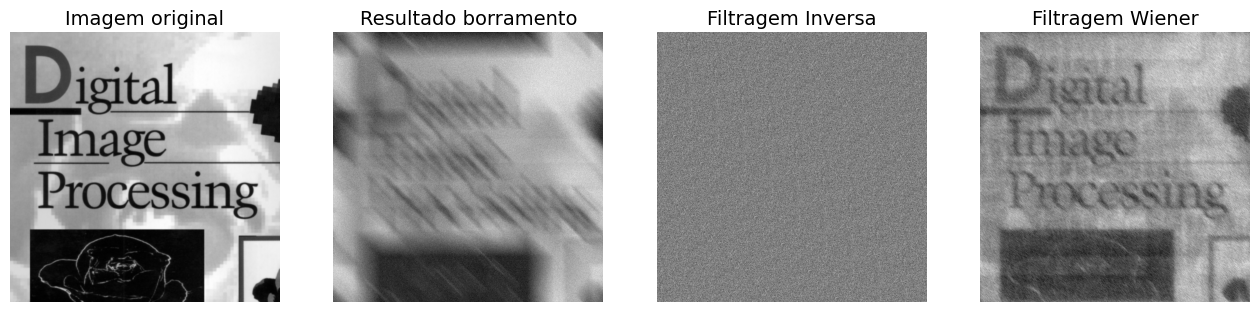

In [ ]:
def calcula_PSNR(img_original, img_filtrada):
    #conversão para tipo float:
    img_original_f = img_original.astype(np.float64)
    img_filtrada_f = img_filtrada.astype(np.float64)
    max_value = 255.0

    #Calculo do MSE:
    erro = img_original_f - img_filtrada_f
    erro_quad = erro**2
    mse = np.sum(erro_quad) / (img_original.shape[0] * img_original.shape[1])
    psnr = 10 * np.log10((max_value** 2) / mse)

    return psnr

def aplica_normalizacao (img):
     #Obtendo os extremos valores de pixel:
     min_value  = np.min (img)
     max_value = np.max (img)
     #Extraindo o tamanho da imagem:
     altura, largura =  img.shape
     img_normalizada = np.zeros((altura, largura), dtype=np.float64)

     if min_value == max_value:
        return np.zeros(img.shape, dtype=np.uint8)

     #fator de escala usando durante a normalizacao:
     escala = 255.0 / (max_value-min_value)
     #percorre a imagem fazendo a normalizacao
     for i in range(altura):
        for j in range(largura):
            pixel_antigo = img[i, j]
            pixel_novo = (pixel_antigo -  min_value) * escala
            img_normalizada[i, j] = pixel_novo

     return img_normalizada.astype(np.uint8)



def centraliza_transformada(img):
    altura, largura = img.shape
    x = np.arange(altura).reshape(-1, 1)
    y = np.arange(largura).reshape(1, -1)
    fator = (-1) ** (x + y)
    img_centrada = img * fator
    return img_centrada

def cria_func_deagradacao (img, a, b,t):
    #Extrai o tamanho da imagem
    altura, largura = img.shape
    #Encontra o ponto central da imagem levando (0,0) para o centro.
    centro_u = largura / 2
    centro_v = altura / 2
    #Criar uma matriz de zero para gerar o filtro de blur.
    H = np.zeros((altura, largura), dtype= np.complex128)
    for v in range(altura):
        for u in range(largura):
           #Passa as coordenadas da matriz para considerar a centralizacao em (0,0)
            u_c = u - centro_u
            v_c = v - centro_v
            #Calcula os termos no interior do sen  e exponencial
            termo_arg = np.pi * (u_c * a + v_c * b)
            #Evita problemas com valores que gerariam erros para o exponencial e funcao seno
            if termo_arg == 0:
                termo_sinc = 1.0
            else:
                    termo_sinc = t * (np.sin(termo_arg) / termo_arg)
            #calcula o  valor da parte exponencial
            termo_exp = np.exp(-1j * termo_arg)
            #Monta o filtro de blur a partir da funcao de degradacao
            H[v, u] = termo_sinc * termo_exp

    return H


def gera_borrao(img, a, b, t, ruido):
    altura, largura = img.shape
    img_centralizada = centraliza_transformada(img)
    #Obtem o filtro de blur utilizado na resolucao
    H = cria_func_deagradacao (img, a, b, t)
    #Obtem a fft da img a ser passada no filtro blur
    img_fft = np.fft.fft2(img_centralizada )
    #Obtem  a imagem borrada
    img_borrada_fft = H * img_fft
    #Desfaz a FFT da imagem com borramento obtida
    img_borrada_cx = np.fft.ifft2(img_borrada_fft)
    #Extrai somente a parte real do resultado
    img_borrada = np.real (centraliza_transformada(img_borrada_cx))
    #Insercao do ruido gaussiano
    ruido = np.random.normal(0, np.sqrt(ruido), img.shape)
    img_borrada_final= img_borrada+ ruido

    return img_borrada_final,H

def filtragem_inversa (img, H):
     img_centralizada = centraliza_transformada(img)
     #passa a imagem a ser filtrada para o dominio  frequencia:
     img_fft = np.fft.fft2(img_centralizada )

     #valor de seguranca paar evitar divisao por 0:
     v = 1e-12

     #executa a filtragem inversa:
     img_hat = img_fft/(H+v)

     #revertendo a fft:
     im_hat_comp = np.fft.ifft2(img_hat)
     img_filt_inv = np.real (centraliza_transformada(im_hat_comp))
     # Normaliza a imagem para a faixa visível
     f_hat = aplica_normalizacao(img_filt_inv)

     return f_hat

def filtragem_wiener (img,H, k):
     img_centrada = centraliza_transformada (img)
     G = np.fft.fft2(img_centrada)
     magn_h = np.abs (H)**2
     #Calculo da correcao:
     corr = magn_h/ (magn_h+k)
     #Calcula a parte referente a filtragem inversa
     filtragem_inv = G/(H +1e-12)
     #aplica o filtro na imagem:
     img_corr = corr * filtragem_inv

     #desfazendo o fft:
     img_corr_complx = np.fft.ifft2(img_corr)
     img_corr_real = np.real(centraliza_transformada(img_corr_complx))

     # Normaliza a imagem para a faixa visível
     img_final = aplica_normalizacao (img_corr_real)
     return img_final

img8 = cv2.imread ("Fig5.26(a).jpg",cv2.IMREAD_GRAYSCALE)
ruido = 200
k =0.01
img_borrada, H = gera_borrao(img8, 0.1,0.1,1,ruido)
img_fil_inv = filtragem_inversa(img_borrada, H)
img_filt_weiner = filtragem_wiener (img_borrada,H, k)
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs[0].imshow(img8, cmap='gray')
axs[0].set_title('Imagem original', fontsize=14)
axs[0].axis('off')
axs[1].imshow(img_borrada, cmap='gray')
axs[1].set_title('Resultado borramento', fontsize=14)
axs[1].axis('off')
axs[2].imshow(img_fil_inv, cmap='gray')
axs[2].set_title('Filtragem Inversa', fontsize=14)
axs[2].axis('off')
axs[3].imshow(img_filt_weiner, cmap='gray')
axs[3].set_title('Filtragem Wiener', fontsize=14)
axs[3].axis('off')


Como pode ser observado, temos que o processo de degradação da imagem funcionou de maneira perfeita, visto que é possível observar que o blur aplicado causa o desfoque da imagem na diagonal, que arrasta o pixel e torna o texto ilegível. Já o ruído gaussiano aplicado é a textura arenosa que foi inserida em toda a imagem.
Para a filtragem utilizando a filtragem inversa, o método não se mostrou funcional, já que a filtragem inversa se baseia em reverter a degradação presente na imagem por meio da divisão da imagem a ser recuperada pela função de degradação $(G/H)$, mas no caso testado temos que o método não se mostrou funcional, piorando ainda mais a imagem resultante da filtragem.
Já a filtragem utilizando o filtro de Wiener foi muito superior, permitindo a visualização dos textos presentes, ainda que não tenha limpado totalmente a imagem. Esse resultado pode ser justificado pela forma como o filtro de Wiener funciona, já que, apesar de utilizar a mesma função de degradação do método de filtragem inversa, temos que ele faz um uso mais inteligente de tal função.

Durante o processo de filtragem, o filtro de Wiener avalia a aplicação ou não do termo de regularização; como nos locais onde o ruído é dominante, o filtro não amplifica o mesmo, fazendo somente a atenuação da frequência em questão. Logo, o resultado entregue é uma versão mais balanceada da filtragem, usando a informação da função de degradação.

In [ ]:
#Calculando PSNR:
PSNR_InV = calcula_PSNR (img8, img_fil_inv)
PSNR_weiner = calcula_PSNR (img8, img_filt_weiner)
print("=============== Cálculo PSNR ==============")
print(f"PSNR para filtragem usando filtro inverso: {PSNR_InV:.3f} db")
print(f"PSNR para filtragem usando filtro weiner: {PSNR_weiner:.3f} db")

=============== Cálculo PSNR ==============
PSNR para filtragem usando filtro inverso: 9.346 db
PSNR para filtragem usando filtro weiner: 14.220 db


Os resultados visuais indicaram uma clara superioridade do Filtro de Wiener na remoção do borrão e supressão do ruído. Esta observação foi confirmada quantitativamente, com o Filtro de Wiener alcançando um PSNR de 14.278 dB, consideravelmente maior que os 9.332 dB obtidos pela Filtragem Inversa, que se mostrou ineficaz na presença dos ruídos.

9) For the images noise1.jpg and noise2.jpg, apply the filters mean 5x5, median 5x5 and the adaptive median filter (ranging from dimensions 3x3 to dimensions 11x11) to treat the noise. Compare with the original image.jpg by calculating the PSNR. Use log10 to calculate the PSNR. Compare the results and discuss.


Como proposto no enunciado do exercício, temos que foi solicitada a implementação de três técnicas de filtragem para a remoção de ruídos do tipo "sal e pimenta". Para isso, são criadas as três funções de filtragem usadas.
Primeiramente, foi implementado um filtro de média, que suaviza a imagem a partir da média da vizinhança. A segunda função implementada é um filtro de mediana, que substitui o pixel pela mediana de todos os valores presentes na vizinhança. E, por fim, foi implementado um filtro adaptativo de mediana, que faz um ajuste de seu comportamento e do tamanho da janela de análise com base nas estatísticas locais (mínimo, máximo e mediana), buscando remover os ruídos de forma seletiva enquanto minimiza detalhes finos presentes na imagem.
Para garantir que as imagens fossem corretamente filtradas, temos que, inicialmente, as mesmas foram tratadas por meio da inserção de padding com a técnica de preenchimento baseada na reflexão das bordas da imagem. A imagem resultante desse procedimento, então, foi filtrada por meio do uso dos três filtros implementados.

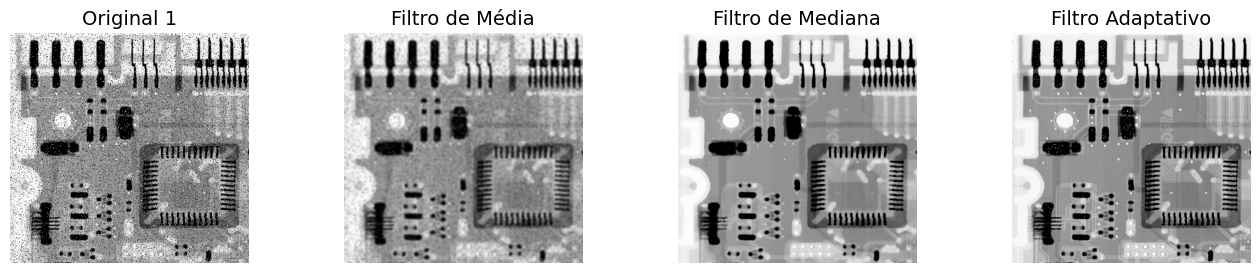

In [ ]:
def calcula_PSNR(img_original, img_filtrada):
    #conversão para tipo float:
    img_original_f = img_original.astype(np.float64)
    img_filtrada_f = img_filtrada.astype(np.float64)
    max_value = 255.0

    #Calculo do MSE:
    erro = img_original_f - img_filtrada_f
    erro_quad = erro**2
    mse = np.sum(erro_quad) / (img_original.shape[0] * img_original.shape[1])
    psnr = 10 * np.log10((max_value** 2) / mse)

    return psnr

def padding_com_reflect (img, dim):
    #Extração dos valores da dimensão da imagem e a dimensão da máscara utilizada.
    img_alt, img_larg= img.shape
    alt_mask=dim
    larg_mask = dim
    #Calculo da dimensão dos paddings utilizados
    pad_alt = alt_mask // 2
    pad_larg = larg_mask // 2
    #Calculo das dimensões da nova imagem considerando o complemento dos pixels considerando o padding:
    new_alt = img_alt + 2 * pad_alt
    new_larg = img_larg + 2 * pad_larg
    #Inicilizando uma nova imagem vazia utilizada para receber a nova imagem com o padding inserido:
    img_aux = np.zeros ((new_alt, new_larg))

    #Copia a imagem original para o centro:
    img_aux[pad_alt:pad_alt + img_alt, pad_larg:pad_larg + img_larg] = img
    # Pega as linhas de 1 a 'pad_alt' da imagem original, inverte a ordem delas e coloca no padding superior
    secao_topo = img[1:pad_alt + 1, :]
    img_aux [0:pad_alt, pad_larg:pad_larg + img_larg] = np.flip(secao_topo, axis=0)
    # Pega as penúltimas N linhas, inverte a ordem e coloca no padding inferior
    secao_base = img[img_alt - pad_alt - 1:img_alt - 1, :]
    img_aux [new_alt - pad_alt:, pad_larg:pad_larg + img_larg] = np.flip(secao_base, axis=0)
    #Preenchimento da esquerda: espelha as primeiras 'pad_larg' colunas
    secao_esquerda = img_aux [:, pad_larg + 1:pad_larg + pad_larg + 1]
    img_aux [:, 0:pad_larg] = np.flip(secao_esquerda, axis=1)
    #Preenchimento da direita: espelha as últimas 'pad_larg' colunas
    secao_direita = img_aux[:, new_larg - pad_larg - pad_larg - 1 : new_larg - pad_larg - 1]
    img_aux[:, new_larg - pad_larg:] = np.flip(secao_direita, axis=1)

    return img_aux

def calcula_filtro_media(img, dim):
    altura, largura = img.shape
    img_padding = padding_com_reflect (img,dim)
    img_filtrada = np.zeros_like(img, dtype= np.float64)

    for i in range (altura):
        for j in range (largura):
            #Extrai a  região com o pixel central analisado:
            subamostra = img_padding[i:i + dim, j:j + dim]
            #percorre a região e calcula a media dos pixels para a insercao na imagem filtrada.
            soma = 0
            for row in range(dim):
                for col in range(dim):
                    soma = soma + subamostra[row, col]
            media = soma / (dim*dim)
            img_filtrada [i,j] = media

    return img_filtrada

def calcula_filtro_mediana(img, dim):
    altura, largura = img.shape
    img_padding = padding_com_reflect (img,dim)
    img_filtrada = np.zeros_like(img, dtype= np.float64)

    for i in range (altura):
        for j in range (largura):
            #Extrai a  região com o pixel central analisado:
            subamostra = img_padding[i:i + dim, j:j + dim]
            #percorre a região e calcula a media dos pixels para a insercao na imagem filtrada.
            mediana = np.median(subamostra)

            #Insere o valor da mediana no local do pixel correspondente:
            img_filtrada[i,j] = mediana

    return img_filtrada

def calcula_filtro_aptativo(img, dim1,dim2):
    altura, largura = img.shape
    img_padding = padding_com_reflect (img,dim2)
    img_filtrada = np.copy(img).astype (np.float64)

    pad_max = dim2 // 2

    for i in range (altura):
        for j in range (largura):
            #Obtem o valor do pixel analisado:
            pixel_central = img[i, j]
            #Recalcula a posicao da imagem considerando o pad inserido com o filtro de maior janela:
            pad_inicial = dim1 // 2
            y_inicio = i + pad_max - pad_inicial
            y_fim = i + pad_max + pad_inicial + 1
            x_inicio = j + pad_max - pad_inicial
            x_fim = j + pad_max + pad_inicial + 1

            #Extrai a  região com o pixel central analisado:
            subamostra = img_padding[y_inicio:y_fim, x_inicio:x_fim]
            #percorre a região e calcula a media dos pixels para a insercao na imagem filtrada.
            medn1= np.median(subamostra)
            maxV1 = np.max(subamostra)
            minV1 = np.min(subamostra)

            # Condição A1: Verifica se o valor da mediana (medn1) não é um ruído (um extremo).
            if minV1 < medn1 < maxV1:
              # Condição A2: Se a mediana não é ruído, verifica se o pixel central também não é.
                if minV1 < pixel_central < maxV1:
                    img_filtrada[i,j] = pixel_central

                # Se o pixel central é um ruído, ele é substituído pela mediana.
                else:
                    img_filtrada[i,j] = medn1
            else:
                stop_flag = False
                for tamanho_janela_atual in range(dim1 + 2, dim2 + 1, 2):
                    #Lógica para descontar o pad de imagem a partir do valor da janela testada:
                    pad_atual = tamanho_janela_atual // 2
                    y_inicio = i + pad_max - pad_atual
                    y_fim = i + pad_max + pad_atual + 1
                    x_inicio = j + pad_max - pad_atual
                    x_fim = j + pad_max + pad_atual + 1

                    subamostra_expandida = img_padding[y_inicio:y_fim, x_inicio:x_fim]
                    # Calcula os valores mínimo, máximo e mediano da vizinhança.
                    medn2= np.median(subamostra_expandida)
                    maxV2 = np.max(subamostra_expandida)
                    minV2 = np.min(subamostra_expandida)
                    # Condição B1: Repete a verificação para a nova mediana.
                    if minV2 < medn2 < maxV2:
                      # Condição B2: Se a nova mediana é um valor bom, verifica o pixel central.
                        if minV2 < pixel_central < maxV2:
                          # Se o pixel central não é um ruído nesta janela maior, ele é mantido.
                            img_filtrada[i, j] = pixel_central
                        else:
                          # Se o pixel central é um ruído, substitui pela nova mediana.
                            img_filtrada[i, j] = medn2

                        stop_flag = True
                        break

                if not stop_flag:
                    img_filtrada[i, j] = pixel_central

    return img_filtrada

#Aplicando o metodo na primeira imagem
img9_1 = cv2.imread ("noise1.tif",cv2.IMREAD_GRAYSCALE)
img_filtrada_media = calcula_filtro_media(img9_1,5)
img_filtrada_mediana = calcula_filtro_mediana (img9_1, 5)
img_filtrada_adapt = calcula_filtro_aptativo(img9_1, 3,11)
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs[0].imshow(img9_1, cmap='gray')
axs[0].set_title('Original 1', fontsize=14)
axs[0].axis('off')
axs[1].imshow(img_filtrada_media, cmap='gray')
axs[1].set_title('Filtro de Média', fontsize=14)
axs[1].axis('off')
axs[2].imshow(img_filtrada_mediana, cmap='gray')
axs[2].set_title('Filtro de Mediana', fontsize=14)
axs[2].axis('off')
axs[3].imshow(img_filtrada_adapt, cmap='gray')
axs[3].set_title('Filtro Adaptativo', fontsize=14)
axs[3].axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()




Como pode ser observado na primeira imagem, temos a presença de ruídos similares a granulação. Para a implementação do filtro de média, ocorreu uma suavização muito boa dos ruídos existentes, porém faz com que ocorra uma perda na nitidez das bordas e dos detalhes mais finos presentes na placa de circuito.
A implementação usando o filtro de mediana apresenta uma melhora significativa em relação ao resultado obtido com o uso do filtro de média, conseguindo reduzir os ruídos e mantendo as bordas mais nítidas.
Por fim, temos o resultado obtido por meio da implementação do filtro de mediana adaptativo, sendo este o método mais eficaz no processo proposto, onde temos uma imagem resultante bem mais limpa e com mais detalhes em relação aos outros resultados, se saindo melhor na tarefa executada. Temos que para verificar qualidade do metódo implementado as imagens usadas para calcular o PSNR obtendo os resultados a seguir:

In [ ]:
#Obtenção do PSNR:
psnr_media = calcula_PSNR(img9_1, img_filtrada_media)
psnr_mediana = calcula_PSNR(img9_1, img_filtrada_mediana)
psnr_adapt = calcula_PSNR(img9_1, img_filtrada_adapt)
print("==== Valores Calculados de PSNR =====")
print(f'Imagem "noise1.tif"')
print(f"PSNR para filtro de média: {psnr_media:.3f} dB")
print(f"PSNR para filtro de mediana:{psnr_mediana:.3f} dB")
print(f"PSNR para filtro de mediana adaptativo: {psnr_adapt:.3f} dB")

==== Valores Calculados de PSNR =====
Imagem "noise1.tif"
PSNR para filtro de média: 14.279 dB
PSNR para filtro de mediana:14.215 dB
PSNR para filtro de mediana adaptativo: 14.596 dB


Os valores obtidos seguem o que pode ser interpretado visualmente nos resultados exibidos nas imagens, onde o filtro de mediana adaptativo é superior aos demais, seguido pelo filtro de mediana e pelo filtro de média, mas muito próximos entre si, devido ao fato de todos os filtros terem conseguido melhorar a imagem original.

Como uma segunda etapa, os métodos de filtragem foram utilizados para melhorar a imagem noise2.tif, que é uma versão com muito mais ruído da primeira imagem testada.

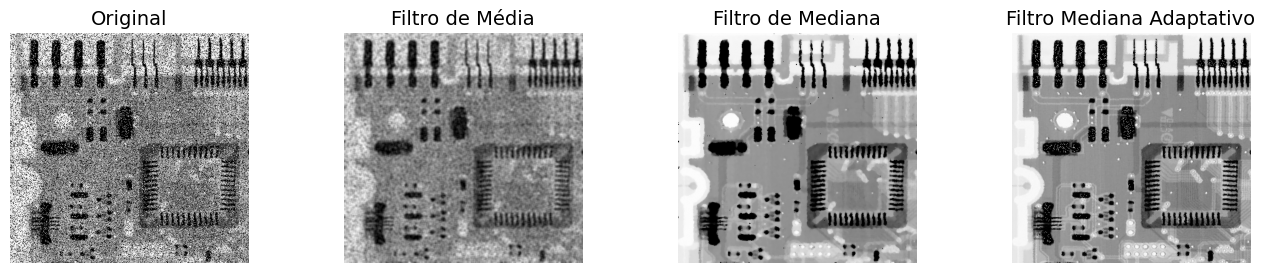

In [ ]:
img9_2 = cv2.imread("noise2.tif", cv2.IMREAD_GRAYSCALE)
img2_filtrada_media = calcula_filtro_media(img9_2, 5)
img2_filtrada_mediana = calcula_filtro_mediana(img9_2, 5)
img2_filtrada_adapt = calcula_filtro_aptativo(img9_2, 3, 11)
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs[0].imshow(img9_2, cmap='gray')
axs[0].set_title('Original', fontsize=14)
axs[0].axis('off')
axs[1].imshow(img2_filtrada_media, cmap='gray')
axs[1].set_title('Filtro de Média', fontsize=14)
axs[1].axis('off')
axs[2].imshow(img2_filtrada_mediana, cmap='gray')
axs[2].set_title('Filtro de Mediana', fontsize=14)
axs[2].axis('off')
axs[3].imshow(img2_filtrada_adapt, cmap='gray')
axs[3].set_title('Filtro Mediana Adaptativo', fontsize=14)
axs[3].axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


Apesar de ser uma imagem com uma quantidade muito maior de ruído, temos que os filtros ainda se mostram eficazes em limpar a imagem. Mas, neste caso, o filtro de média teve um resultado muito inferior ao primeiro caso, não removendo quase nenhum ruído da imagem e a deixando com um aspecto muito borrado.
No filtro de mediana, temos uma melhora significativa na imagem resultante, onde os ruídos foram removidos em sua grande maioria, mas podemos notar que os detalhes mais finos da imagem possuem um pouco de distorção e sujeira.
Por fim, temos o filtro adaptativo, que apresenta o melhor resultado, onde temos uma imagem bem mais limpa do que nos outros dois resultados e com os detalhes finos presentes mais nítidos.

In [ ]:
#Obtenção do PSNR:
psnr_media2 = calcula_PSNR(img9_2, img2_filtrada_media)
psnr_mediana2 = calcula_PSNR(img9_2, img2_filtrada_mediana)
psnr_adapt2 = calcula_PSNR(img9_2, img2_filtrada_adapt)
print("==== Valores Calculados de PSNR =====")
print(f'Imagem "noise2.tif"')
print(f"PSNR para filtro de média: {psnr_media2:.3f} dB")
print(f"PSNR para filtro de mediana:{psnr_mediana2:.3f} dB")
print(f"PSNR para filtro de mediana adaptativo: {psnr_adapt2:.3f} dB")


==== Valores Calculados de PSNR =====
Imagem "noise2.tif"
PSNR para filtro de média: 10.295 dB
PSNR para filtro de mediana:9.669 dB
PSNR para filtro de mediana adaptativo: 9.947 dB


O resultado obtido para a métrica do PSNR se mostrou contrário ao que foi visto visualmente, mas isso pode ser justificado pelo fato de que, como a imagem original possui muito ruído, quando é utilizado o filtro de média, a mudança feita é mínima. Logo, em uma comparação com a imagem original, temos que o resultado do PSNR será maior.
Enquanto isso, para os filtros onde ocorrem as mudanças mais significativas, como o de mediana e o filtro adaptativo de mediana, temos que o resultado do PSNR é inferior justamente pelo fato de os pixels com ruído serem removidos e substituídos por valores mais adequados, melhorando a imagem obtida na saída.

Comparando os resultados obtidos para as duas imagens, os filtros se saíram bem no processo de filtragem, ainda que a segunda imagem estivesse com muito mais ruído do que a primeira imagem.
Mas temos uma diferença visível no PSNR obtido nos dois casos. Para o primeiro caso, temos que o PSNR apresentou um resultado mais equilibrado e que segue o que foi visto visualmente nas imagens obtidas, onde o melhor resultado está diretamente relacionado ao melhor resultado de filtragem.
Já no segundo caso, temos que os resultados foram inferiores e seguem de maneira inversa ao que pode ser visualizado nas imagens. Mas isso pode ser justificado justamente pelo fato de que as imagens filtradas são muito diferentes da original. Isso faz com que, em uma métrica como o PSNR, onde se considera a proximidade dos pixels da imagem original e da imagem obtida no processo de filtragem, a imagem mais limpa, por ser muito diferente da original, apresente um menor valor para a métrica.

##Theoretical questions:


1) Explain with your words the process to obtain a digital image from a continuous
image (consider that (x,y) coordinates and f amplitude are continuous). Make the
considerations regarding spatial and intensity resolution.


O processo para obtenção de uma imagem digital com coordenadas (x,y)  e amplitude(f) vai se basear no uso de dois processos que ocorrem de forma complementar: a quantização e a amostragem.

A primeira etapa realizada é a amostragem, que consiste na discretização das coordenadas espaciais (x,y) da imagem. Durante tal etapa a imagem é subdividida como se estivesse por baixo de uma grade regular, para cada  ponto de intersecção dessa grade teórica é mostrado um valor da função de intensidade. Como resultado, a imagem contínua é convertida em uma matriz de pontos discretos (pixels).

A qualidade da imagem amostrada está diretamente relacionada à sua resolução espacial, que representa a densidade de pixels por área. Uma alta resolução  entrega permite a visualização de detalhes mais finos, enquanto uma baixa resolução leva a uma amostragem  com possíveis perdas de detalhes  e sugimentos de problemas como ruídos, aliasing e borramentos.

Após a amostragem é feita a quantização, onde ocorre a digitalização dos pixels contínuos. Isso é feito de valores de intensidade em um número finito de níveis, que podem ser como 256 níveis para uma imagem com 8 bits, associando cada valor amostrado a um nível discreto mais próximo.

O conceito de resolução de intensidade está diretamente relacionado ao que é feito durante o processo de quantização, podendo ser definido como o número de níveis discretos  usados para representar as intensidades dos pixels. Quanto mais elevado o valor da resolução de intensidade, de maneira mais fiel são representados os brilhos presentes na imagem original.

A qualidade final obtida durante o processo de conversão de uma imagem contínua em uma imagem digital está diretamente ligado a resolução espacial e as intesidades utilizadas no processo de conversão.

2) How would you explain spatial frequency in an image?


A frequência espacial é definida como sendo a taxa de variação dos valores de intensidade (brilho) dentro de uma determinada imagem. Esse conceito é similar ao som ou a outros sinais que apresentam variações ao longo do tempo, onde se avalia a velocidade com a qual tais valores mudam. Em uma imagem, as intensidades das cores variam espacialmente ao longo das regiões às quais pertencem (largura e altura).

Em imagens com muitos detalhes finos, bordas e texturas, temos a presença de alta frequência espacial, enquanto em regiões mais suaves e uniformes, com variações lentas de intensidade, temos a presença de baixa frequência espacial.

O conceito de frequência espacial é a base para métodos de filtragem. Um filtro passa-baixa, por exemplo, atenua as altas frequências, suavizando a imagem. Já um filtro passa-alta realiza o processo oposto, realçando bordas a partir da atenuação das baixas frequências.

3) List and explain the problems related to filtering in the frequency domain and the use of DFT for this purpose. What can be done to reduce/avoid these problems?


O processo de filtragem no domínio da frequência com a DFT consiste em uma simplificação do procedimento de convolução realizado no domínio espacial, visto que, nesse caso, a convolução é transformada em uma multiplicação ponto a ponto entre a imagem e o filtro implementado no domínio da frequência. Apesar dessa simplificação, esse procedimento pode ocasionar problemas como:

1. Aliasing:
Ocorre quando as altas frequências presentes na imagem original são interpretadas como frequências mais baixas após a amostragem, gerando distorções e artefatos que não podem ser corrigidos posteriormente. O aliasing é causado por uma subamostragem, ou seja, quando não se respeita a taxa de Nyquist — que exige uma taxa de amostragem superior ao dobro da maior frequência presente na imagem.
O aliasing pode se manifestar como padrões de Moiré (listras ou grades repetitivas) ou bordas serrilhadas ("jaggies").
Para evitar esse problema, a principal estratégia é amostrar a imagem em uma taxa superior à de Nyquist. Também é possível atenuar as altas frequências antes da amostragem aplicando um filtro passa-baixa antialiasing, reduzindo assim o risco de distorções.

2. Erro de Wraparound:
Esse erro está diretamente relacionado à periodicidade implícita da Transformada Discreta de Fourier. No domínio da frequência, a convolução corresponde a uma convolução circular no domínio espacial.
Caso a imagem e o filtro não sejam preenchidos com zeros (zero-padding) de forma adequada, ocorre uma sobreposição dos períodos de convolução, gerando distorções conhecidas como erro de wraparound.
Para evitar isso, tanto a imagem quanto o filtro devem ser estendidos com zeros até um tamanho $P×QP×Q$, onde $P≥M+m−1P≥M+m−1$ e $Q≥N+n−1Q≥N+n−1$, com $M×NM×N$ sendo o tamanho da imagem e $m×nm×n$ o tamanho do filtro. Esse preenchimento garante que a convolução circular se comporte como uma convolução linear, preservando a integridade do resultado.

3. Vazamento espectral:
Ocorre quando a imagem apresenta descontinuidades nas bordas ou não possui uma transição suave entre os extremos. Isso faz com que a energia espectral se espalhe (leakage), dificultando a análise no domínio da frequência.
Esse problema pode ser reduzido com o uso de funções de janelamento (como as janelas de Hamming ou Hann) aplicadas à imagem antes da Transformada Discreta de Fourier, suavizando as bordas e reduzindo o vazamento.

4. Artefatos de borda:
São distorções visuais localizadas nas regiões de borda da imagem que surgem após o processo de filtragem. Esses artefatos resultam de transições abruptas e podem ser suavizados utilizando técnicas de padding com reflexão ou espelhamento das bordas, o que evita descontinuidades bruscas e melhora a qualidade do resultado filtrado.


4) Explain the optimum notch filtering procedure and in which situations it is interesting to use it.

Os filtros notch são usados em processos de restauração de imagens, sendo filtros do tipo seletivo. Em processos de filtragem que envolvem o uso de filtros notch, em síntese o que é feito é a remoção de ruídos periódicos, principalmente em casos onde se tem múltiplos componentes de interferência e se faz necessário se manter o máximo possível dos detalhes e informações contidas na imagem original. Nesse caso, o filtro notch ideal minimiza a variância local da imagem restaurada.
Os filtros notch ótimos são interessantes em situações onde um filtro rejeita-banda convencional iria remover muita informação da imagem e os ruídos no espectro de Fourier não são facilmente perceptíveis.
O processo de implementação de um filtro notch pode ser descrito como sendo:

1. A imagem a ser filtrada é submetida a uma transformada de Fourier 2D a imagem obtida nesse processo então tem o espectro deslocado para centralizar as baixas frequências. Quando no domínio da frequência, o ruído periódico passa a conter picos mais definidos e afastados do centro do espectro.

2. Essa imagem centralizada permite a identificação dos picos e os seus pontos simétricos; isso permite a construção do filtro notch.

3. Um filtro notch pode ser projetado a partir de um passa-baixa por um processo de deslocamento e inversão da equação do filtro passa-baixa, como demonstrado a seguir:

$$
 H_{passa-baixa} (u,v) = \frac{1}{1 + \frac{D(u,v)}{D_0}^{2n}}
$$

Em um filtro notch é feito um deslocamento do centro do pico do ruído $(u_k,u_v)$ e $(-u_k​,-u_v​)$, então o efeito do filtro é invertido, se obtendo um passa-faixa a partir da versão simétrica do mesmo.
$$
H(u, v) = \prod_{k=1}^{Q} \left[ \frac{1}{1 + \left( \frac{D_k(u, v)}{D_0} \right)^{2n}} \cdot \frac{1}{1 + \left( \frac{D_{-k}(u, v)}{D_0} \right)^{2n}} \right]
$$

onde
$$
D_k(u, v) = \sqrt{(u - u_k)^2 + (v - v_k)^2}, \quad D_{-k}(u, v) = \sqrt{(u + u_k)^2 + (v + v_k)^2}
$$

Esse filtro implementado irá atenuar as frequências próximas $(u_k,u_v)$​ e $(−u_k,−u_v)$.

5. O filtro é aplicado no espectro da imagem a partir de um processo de multiplicação; isso atenua as frequências indesejadas.

6. A imagem resultante filtrada é obtida a partir da aplicação da transformada inversa de Fourier na imagem obtida na etapa anterior.
